<hr style="height: 1px;">
<i>This notebook was authored by the 8.S50x Course Team, Copyright 2022 MIT All Rights Reserved.</i>
<hr style="height: 1px;">
<br>

<h1>PSet 2: Matched Filtering Part: Time Domain and Frequency Domain</h1>


<a name='section_6_0'></a>
<hr style="height: 1px;">


## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">P2.0 Overview</h2>


<h3>Navigation</h3>

<table style="width:100%">
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_6_1">P2.1 What is Matched Filtering?</a>
        </td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#problems_6_1">P2.1 Problems</a>
        </td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_6_2">P2.2 Fitting in the Time Domain: Part I</a>
        </td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#problems_6_2">P2.2 Problems</a>
        </td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_6_3">P2.3 Fitting in the Time Domain: Part II</a>
        </td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#problems_6_3">P2.3 Problems</a>
        </td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_6_4">P2.4 Sweeping the Time Window</a>
        </td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#problems_6_4">P2.4 Problems</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_7_1">P2.5 Introduction to Fitting in the Frequency Domain</a>
        </td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;">no problems</td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_7_2">P2.6 Analysis of Noisy Car Horn Data</a>
        </td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#problems_7_2">P2.6 Problems</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_7_3">P2.7 Calculating a Better Chi-square for the LIGO Model</a>
        </td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#problems_7_3">P2.7 Problems</a></td>
    </tr>
</table>

<h3>Learning Objectives</h3>

In this Pset we will define matched filtering and look at an example in the time domain.

<h3>Importing Libraries</h3>

Before beginning, run the cell below to import the relevant libraries for this notebook.

In [ ]:
#>>>RUN: P2.0-runcell00

!pip install lmfit

In [1]:
#>>>RUN: P2.0-runcell01

import numpy as np                 #https://numpy.org/doc/stable/
import matplotlib.pyplot as plt    #https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html
from mpl_toolkits import mplot3d   #https://matplotlib.org/2.0.2/mpl_toolkits/mplot3d/tutorial.html

import scipy.stats as stats        #https://docs.scipy.org/doc/scipy/reference/stats.html
from scipy.stats import chisquare  #https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html

import lmfit
from lmfit import Model,Parameters #https://lmfit.github.io/lmfit-py/parameters.html
                                     #https://lmfit.github.io/lmfit-py/model.html#lmfit.model.Model

from scipy.io.wavfile import write   #https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.write.html


<h3>Setting Default Figure Parameters</h3>

The following code cell sets default values for figure parameters.

In [2]:
#>>>RUN: P2.0-runcell02

#set plot resolution
%config InlineBackend.figure_format = 'retina'

#set default figure parameters
plt.rcParams['figure.figsize'] = (9,6)

medium_size = 12
large_size = 15

plt.rc('font', size=medium_size)          # default text sizes
plt.rc('xtick', labelsize=medium_size)    # xtick labels
plt.rc('ytick', labelsize=medium_size)    # ytick labels
plt.rc('legend', fontsize=medium_size)    # legend
plt.rc('axes', titlesize=large_size)      # axes title
plt.rc('axes', labelsize=large_size)      # x and y labels
plt.rc('figure', titlesize=large_size)    # figure title

<a name='section_6_1'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">P2.1 What is Matched Filtering?</h2>    

| [Top](#section_6_0) | [Previous Section](#section_6_0) | [Problems](#problems_6_1) | [Next Section](#section_6_2) |


<h3>Overview</h3>

The purpose of matched filtering is to scan big data sets looking for some kind of signal. LIGO does this to look for gravitational waves in their strain data. Matched filtering is also done in many other fields.

The output of this process is usually a plot of the signal to noise ratio (SNR) for the data. If you're looking for point sources in astrophysical telescope data, for example, the plot is an image  with right ascension and declination as the axes and SNR shown as the z axis (contours or simply brightness). The LIGO analysis uses a 2D plot with time on the x axis and SNR on the y axis.


Signals look like large spikes in the SNR.

To make this exercise useful to you in the LIGO project, we'll make a model signal that resembles a black hole merger. Run the code below to generate and plot an example of the waveform. (This is nearly the same function as was used in Guided Problem Set 3).

Note, in particular, that the input parameter `TIME_TRUE` corresponds to the time at which the signal function has its maximum value. This will be important to remember in the analysis that follows.

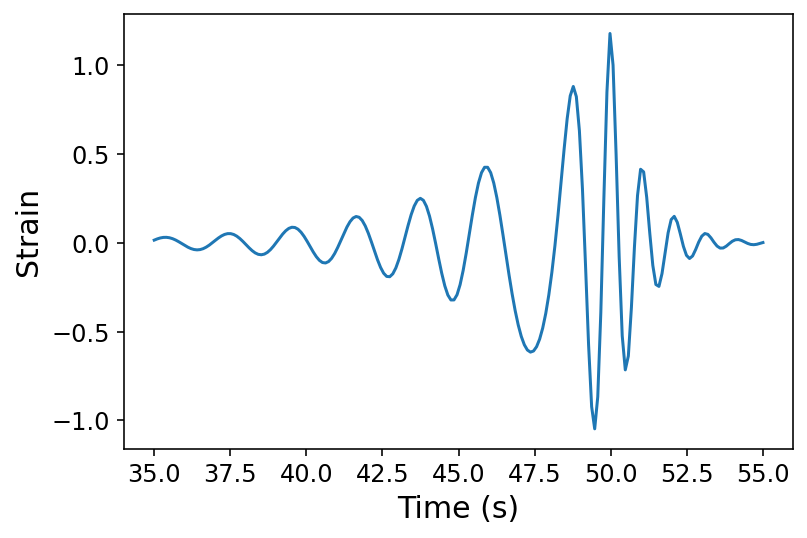

In [3]:
#>>>RUN: P2.1-runcell01

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0x98a09fe)

def complicated_model_fn(x, time, lambda_plus, lambda_minus, max_amp, omega_0, omega_max, omega_sigma):
    omega = (omega_max - omega_0) * (np.exp(-np.minimum(x - time, 0)**2 / omega_sigma)) + omega_0
    lambdas = np.array([lambda_plus if xvalue > time else lambda_minus for xvalue in x])
    amplitude = max_amp * np.exp(-abs(x - time) / lambdas)
    return amplitude * np.cos(omega * (x-time))

LAMBDA_PLUS_TRUE = 1.0
LAMBDA_MINUS_TRUE = 4
MAX_AMP_TRUE = 1.2
OMEGA_0_TRUE = 3.0
OMEGA_MAX_TRUE = 6.0
OMEGA_SIGMA_TRUE = 4.0
TIME_TRUE = 50.0

xi = np.linspace(TIME_TRUE-15, TIME_TRUE+5, 200)
yi_true = complicated_model_fn(xi, TIME_TRUE, LAMBDA_PLUS_TRUE, LAMBDA_MINUS_TRUE, MAX_AMP_TRUE,
                               OMEGA_0_TRUE, OMEGA_MAX_TRUE, OMEGA_SIGMA_TRUE)

plt.plot(xi, yi_true)
plt.xlabel("Time (s)")
plt.ylabel("Strain");

Now, let's make some fake data using this waveform as a merger signal and superimposing simulated "noise" as ten sinusoids of varying frequency, phase, and amplitude added together. Make sure you take the time to read the code and understand exactly what it does.

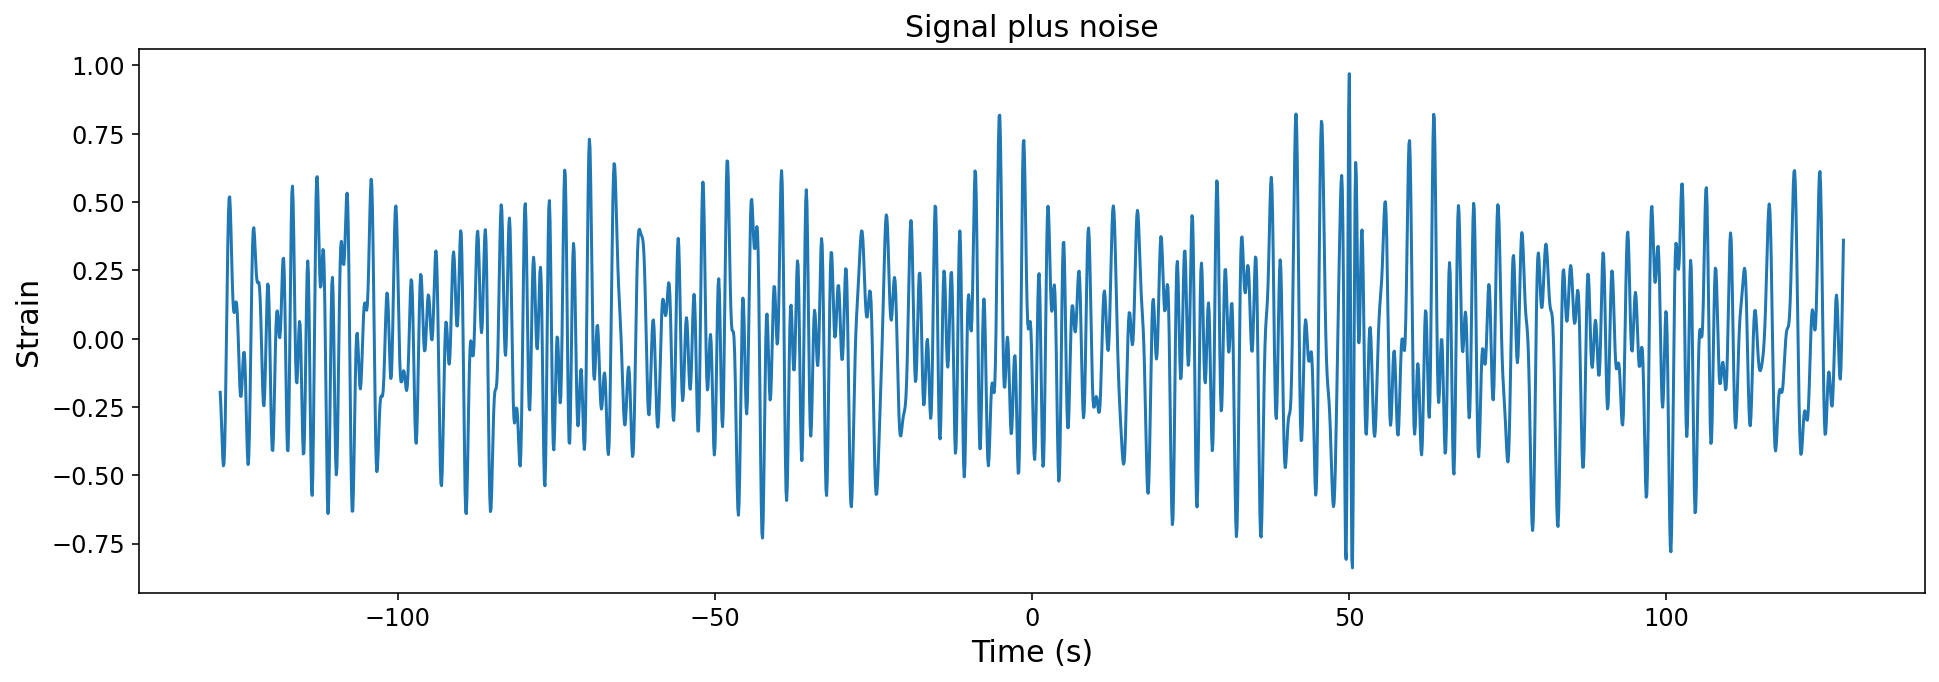

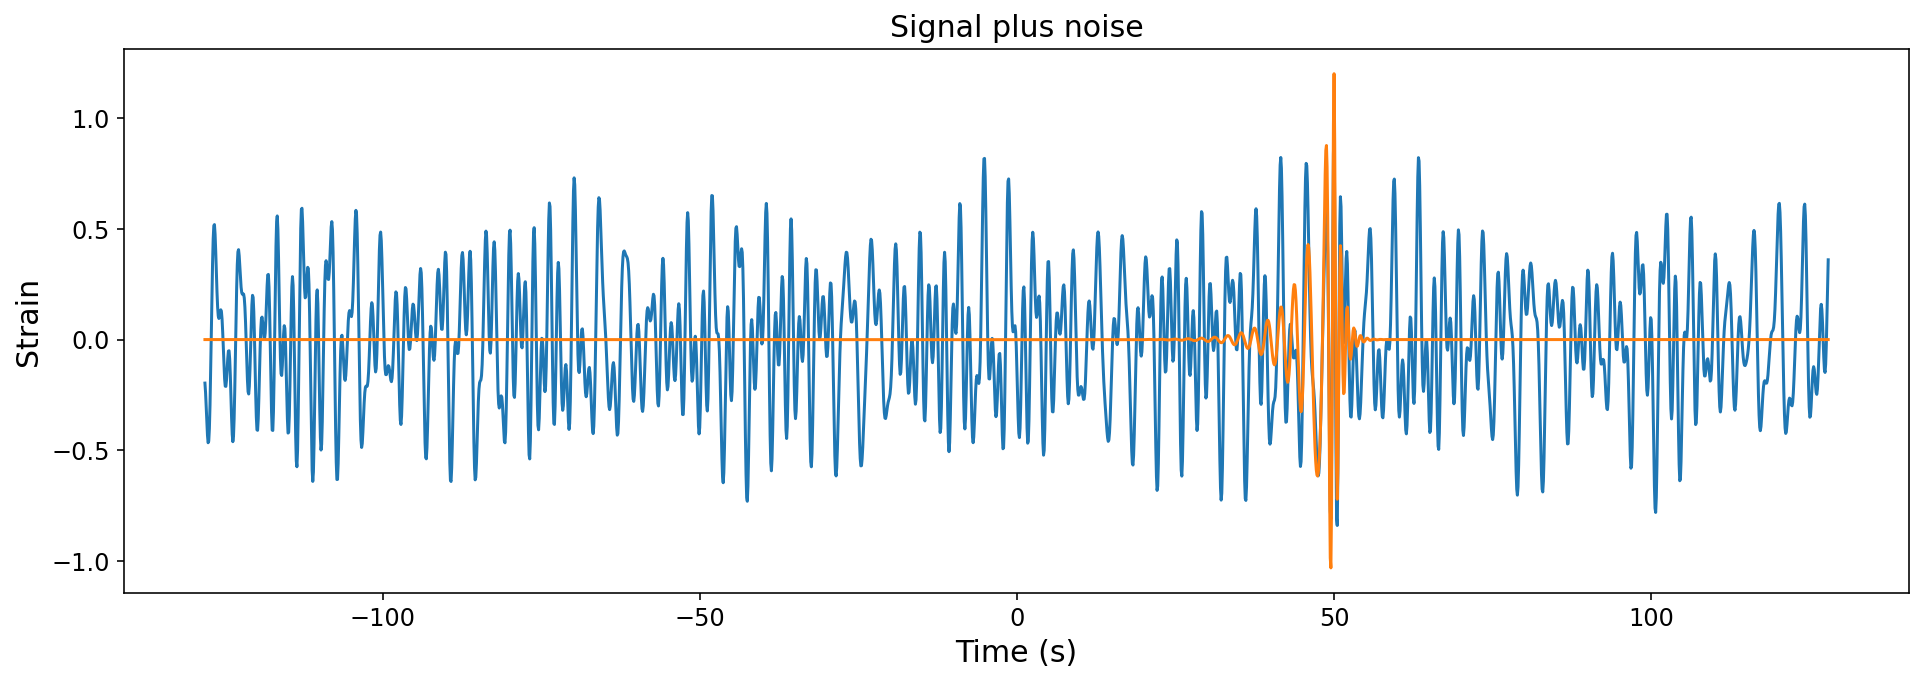

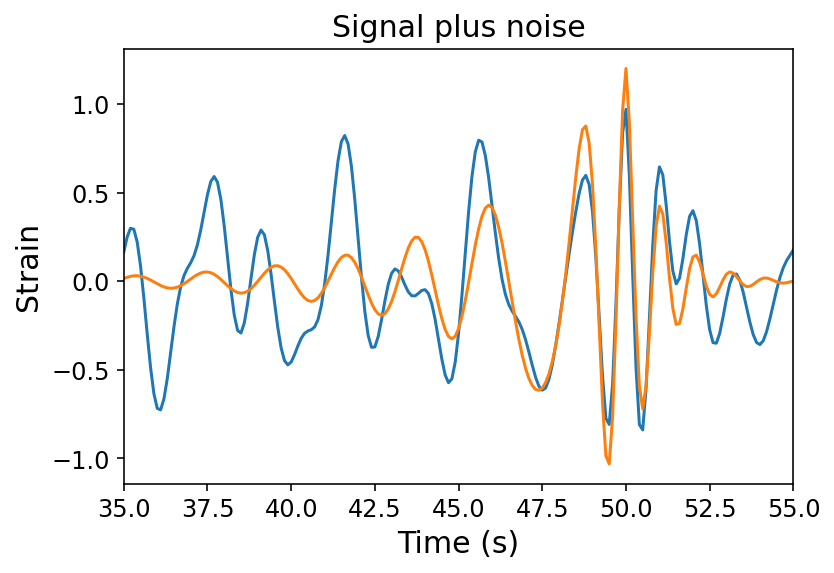

In [4]:
#>>>RUN: P2.1-runcell02

np.random.seed(0x98a09fe)
#np.random.seed(908)

NUMBER_SINES_TO_ADD = 10

noise_frequencies = 0.5 + 7 * np.random.random(NUMBER_SINES_TO_ADD)
noise_phases = 2 * np.pi * np.random.random(NUMBER_SINES_TO_ADD)
noise_amplitudes = 2 * MAX_AMP_TRUE / NUMBER_SINES_TO_ADD * np.random.random(NUMBER_SINES_TO_ADD)
    # The above line sets noise amplitudes so that the sum of all the noise amplitudes is on average
    # equal to the maximum amplitude of the signal.

sample_spacing = 0.1
xi = np.arange(-128, 128, sample_spacing)#times
yi = np.zeros_like(xi)#data

#Adding Noise
for freq, phase, amplitude in zip(noise_frequencies, noise_phases, noise_amplitudes):
    yi += amplitude * np.sin(phase + freq * xi)
   
#Adding Data
signal = complicated_model_fn(xi, TIME_TRUE, LAMBDA_PLUS_TRUE, LAMBDA_MINUS_TRUE, MAX_AMP_TRUE,
                               OMEGA_0_TRUE, OMEGA_MAX_TRUE, OMEGA_SIGMA_TRUE)

yi+=signal

plt.figure(figsize=(16, 5))
plt.plot(xi, yi)
plt.title("Signal plus noise")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(xi, yi)
plt.plot(xi, signal)
plt.title("Signal plus noise")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.show()

plt.plot(xi, yi)
plt.plot(xi, signal)
plt.title("Signal plus noise")
plt.xlim(35,55)
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.show()

When you blow up the region around t=TRUE_TIME and overlay the signal waveform, the correspondence is clear, but could you figure this out given only the noisy data in the first plot? **Our goal is to accomplish the seemingly impossible task of finding the signal in this data.**


<a name='problems_6_1'></a>     

| [Top](#section_6_0) | [Restart Section](#section_6_1) | [Next Section](#section_6_2) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 2.1.1</span>

In the next four problems, we will generate some noise and create a SNR (signal to noise ratio) plot in order to identify the time at which the signal exists. Since we already know the signal and the noise separately, we can implement a naive approach to finding the signal time. We will calculate the SNR and then simply take the time at which its maximum occurs as the time for the signal event. Your goal is to explore how well this crude method works.

First, generate some noise composed of 1,000 sines (100 times as many as above!) with frequencies randomly taken from a normal distribution with mean at $\mu=0.8$ and standard deviation of $\sigma =5$, phases taken from a random uniform distribution ranging from 0 to $2\pi$, and amplitudes set so that the sum of all the noise amplitudes is on average equal to the maximum amplitude of the signal.

In a previous assignment, we did something similar with only 10 sines, but we sampled from slightly different distributions. You can refer back to that previous example, if necessary.

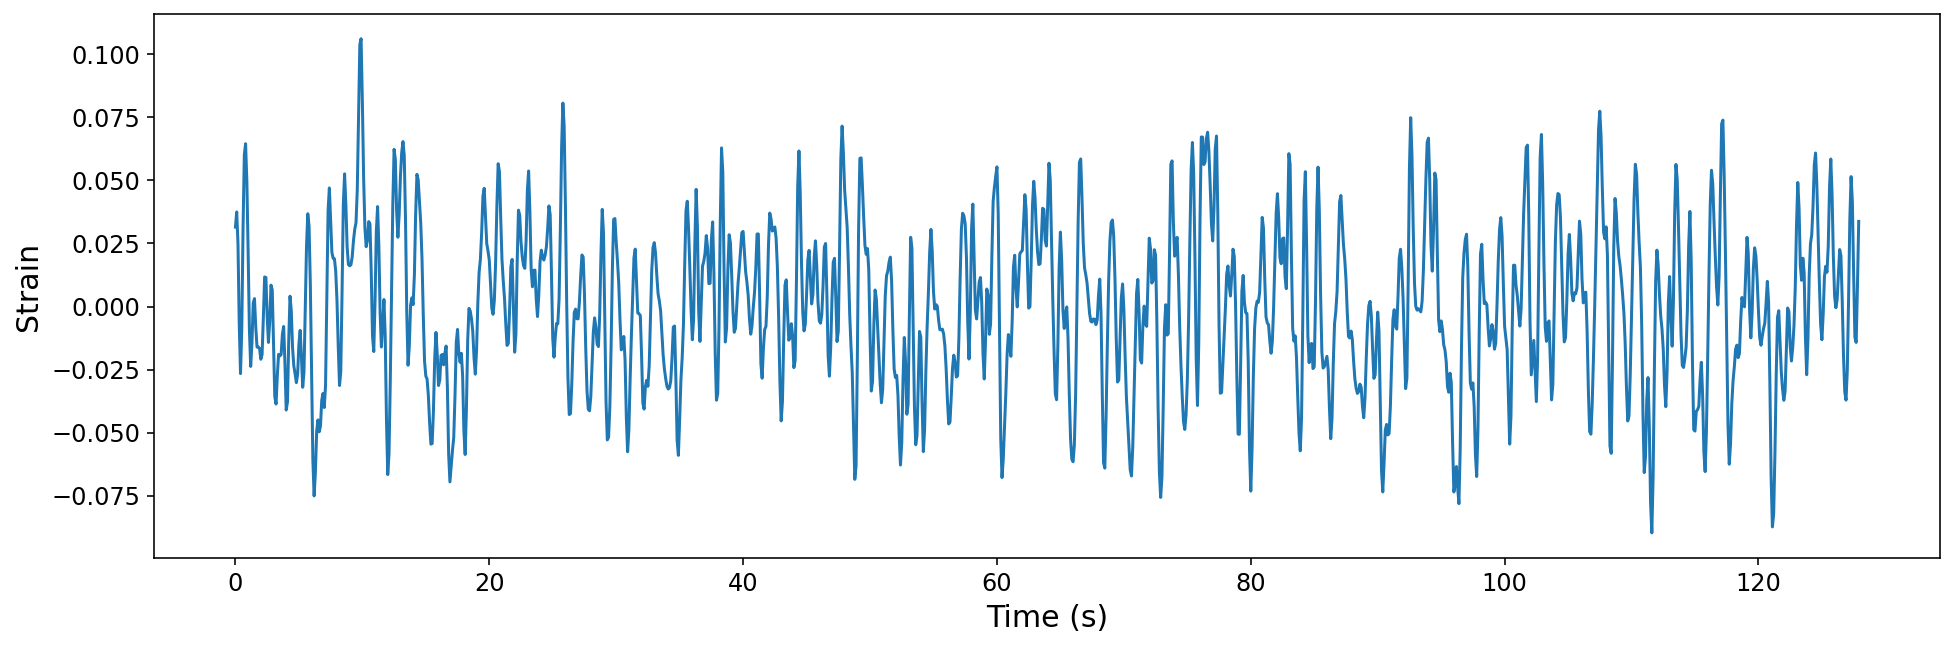

In [5]:
#>>>PROBLEM: P2.1.1
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.

MAX_AMP_TRUE = 1.2
SAMPLE_SPACING = 0.1
NUMBER_SINES_TO_ADD = 1000

xi = np.arange(0, 128, SAMPLE_SPACING)#times

def generate_noise(xi):
    np.random.seed(908)
    yi_noise = np.zeros_like(xi)

    noise_frequencies = np.random.normal(loc=0.8, scale=5, size=NUMBER_SINES_TO_ADD)
    noise_phases = np.random.uniform(low=0., high=2*np.pi, size=NUMBER_SINES_TO_ADD)
    noise_amplitudes = 2 * MAX_AMP_TRUE / NUMBER_SINES_TO_ADD * np.random.random(NUMBER_SINES_TO_ADD)
    # The above line sets noise amplitudes so that the sum of all the noise amplitudes is on average
    # equal to the maximum amplitude of the signal.

    #Adding Noise
    for freq, phase, amplitude in zip(noise_frequencies, noise_phases, noise_amplitudes):
        yi_noise += amplitude * np.sin( phase + freq * xi)

    return yi_noise

plt.figure(figsize=(16, 5))
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.plot(xi, generate_noise(xi))
plt.show()


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 2.1.2</span>

Now, we want to inject a signal waveform on top of the noise signal we just generated. Then, we will use a very simple approach to try to "find" that signal, namely looking for the location in the total amplitude which has the maximum value. Recall that the maximum amplitude of the merger signal is the parameter `TRUE_TIME`. So,  we can determine how well we "found" the injected signal by checking if the time we found in the total data is consistent with the `TRUE_TIME` of the injected waveform. 

To begin, create a set of 50 signals of the form shown earlier. Except for the `TRUE_TIME`, each waveform will have identical parameters as shown in the code below. The `TRUE_TIME` parameters of the injected signals should range over every whole second in the range [50, 100) (i.e., you should generate signals with `TRUE_TIME`=50, `TRUE_TIME`=51, ... `TRUE_TIME`=99).

For each merger signal, inject it on top of the noise generated earlier and try to find the time at which the injection happens by looking for the maximum amplitude in the combined data. Lastly, make a plot of the true (injected) time, vs the time at which you found the maximum. Notice the `scale` parameter in the function `get_max_times`. This option can be used to rescale the size of the merger signal before it gets injected (in this case, `scale=1.0`, so we used the unmodified merger waveform). 

HINT: Take a look at the `np.argmax()` function.


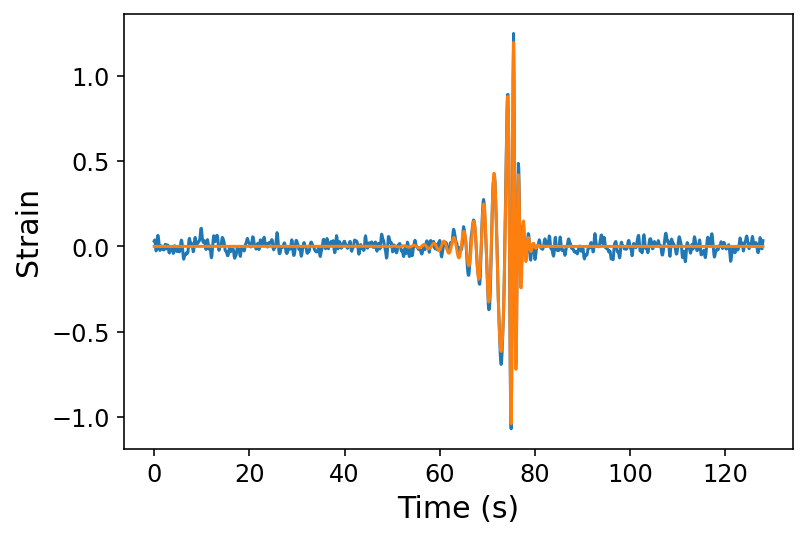

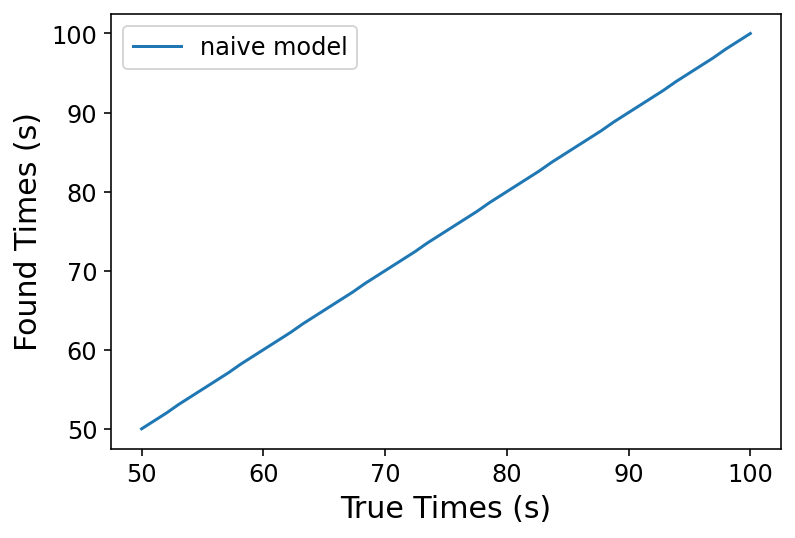

In [18]:
#>>>PROBLEM: P2.1.2
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.

LAMBDA_PLUS_TRUE = 1.0
LAMBDA_MINUS_TRUE = 4
MAX_AMP_TRUE = 1.2
OMEGA_0_TRUE = 3.0
OMEGA_MAX_TRUE = 6.0
OMEGA_SIGMA_TRUE = 4.0

def complicated_model_fn(x, time, lambda_plus, lambda_minus, max_amp, omega_0, omega_max, omega_sigma):
    omega = (omega_max - omega_0) * (np.exp(-np.minimum(x - time, 0)**2 / omega_sigma)) + omega_0
    lambdas = np.array([lambda_plus if xvalue > time else lambda_minus for xvalue in x])
    amplitude = max_amp * np.exp(-abs(x - time) / lambdas)
    return amplitude * np.cos(omega * (x-time))

def get_max_times(xi, yi_noise, true_times,scale=1.0,iCheck=False):
    time_of_maximums = []

    for t in true_times:

        yi_signal = complicated_model_fn(xi, t, LAMBDA_PLUS_TRUE, LAMBDA_MINUS_TRUE, MAX_AMP_TRUE, OMEGA_0_TRUE, OMEGA_MAX_TRUE, OMEGA_SIGMA_TRUE)
        yi_test_noise = yi_noise + scale*yi_signal
        SNR = np.abs(yi_test_noise)
        
        time_of_maximums.append(xi[np.argmax(SNR)])
        
        if int(t) == 75 and iCheck:
            plt.xlabel("Time (s)")
            plt.ylabel("Strain")
            plt.plot(xi,yi_test_noise)
            plt.plot(xi,yi_signal)
            plt.show()
        
    return time_of_maximums

true_times = np.linspace(50, 100, 50)
xi = np.arange(0, 128, SAMPLE_SPACING)
yi_noise = generate_noise(xi)

plt.plot(true_times, get_max_times(xi, yi_noise, true_times, iCheck=True), label = 'naive model')
plt.xlabel('True Times (s)')
plt.ylabel('Found Times (s)')
plt.legend()
plt.show()

In [19]:
ans = list(get_max_times(xi, yi_noise, true_times))
print(ans)

[50.0, 51.0, 52.0, 53.1, 54.1, 55.1, 56.1, 57.1, 58.2, 59.2, 60.2, 61.2, 62.2, 63.300000000000004, 64.3, 65.3, 66.3, 67.3, 68.4, 69.4, 70.4, 71.4, 72.4, 73.5, 74.5, 75.5, 76.5, 77.5, 78.60000000000001, 79.60000000000001, 80.60000000000001, 81.60000000000001, 82.60000000000001, 83.7, 84.7, 85.7, 86.7, 87.7, 88.80000000000001, 89.80000000000001, 90.80000000000001, 91.80000000000001, 92.80000000000001, 93.9, 94.9, 95.9, 96.9, 98.0, 99.0, 100.0]


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 2.1.3</span>

The code for the previous problem plotted the found time versus the true time (true time on the x-axis, estimated time for y) and that result looked quite good. Let's check this comparison more carefully. 

First, modify the code below to add to the plot what a perfect algorithm would look like, namely the line y=x. You might want to give this line a different color so you can distinguish it from the data result, and plot it *after* the other line to put it on top. 

Then, make a second plot showing the fractional difference of the two times (found-true/true) versus the true time.

How well does the results of this crude method compare to a perfect algorithm? Select the best answer below:

- The crude method is an almost exact match to the ideal algorithm.

- The crude method mostly gets the time at which the signal event occurs and occasionally overestimates/underestimates.

- The crude method largely underestimates the time at which the signal event occurs but occasionally gets close or overestimates.

- The crude method largely overestimates the time at which the signal event occurs but occasionally gets close or underestimates.

- The crude method always underestimates the time at which the signal event occurs.

- The crude method always overestimates the time at which the signal event occurs.

- The crude method almost never gets the right answer. 

- The crude method doesn't work at all.


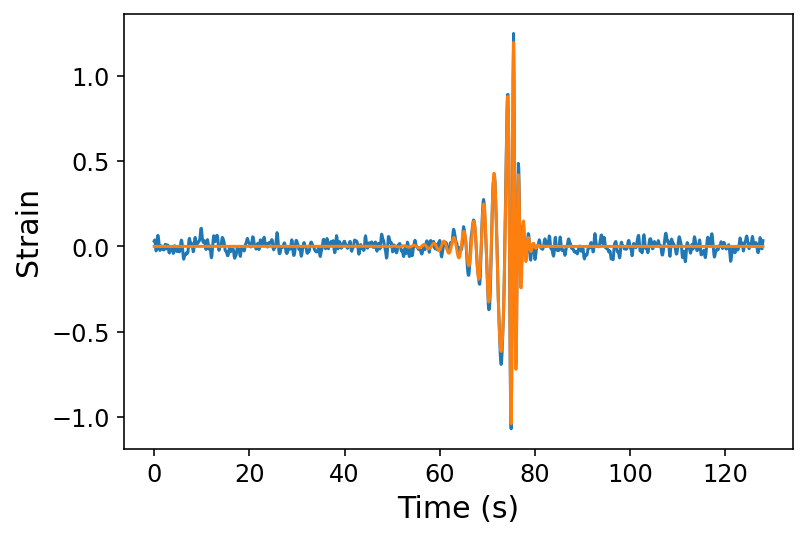

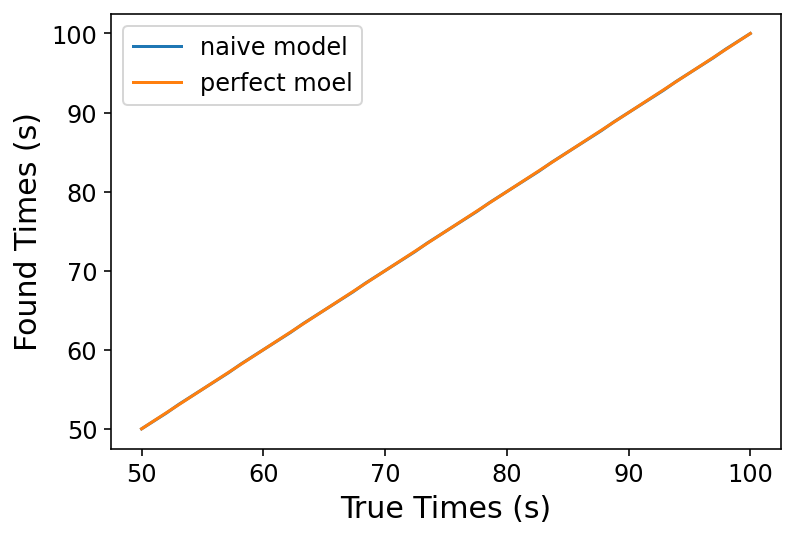

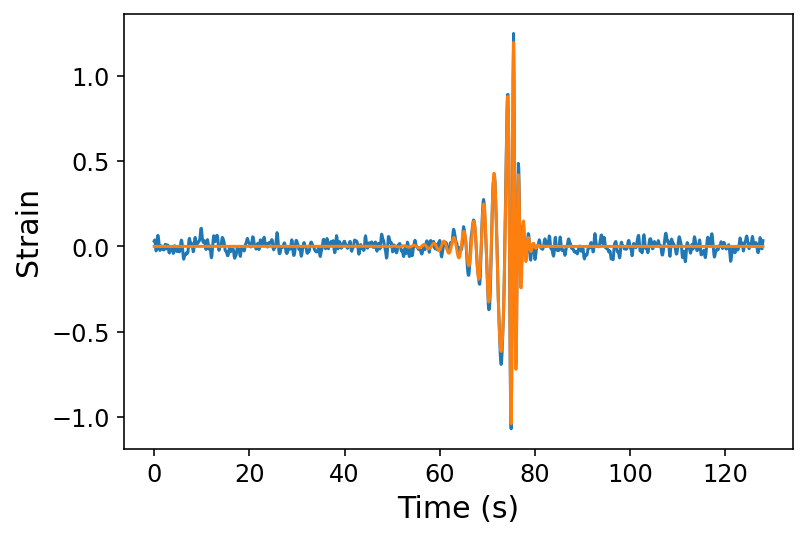

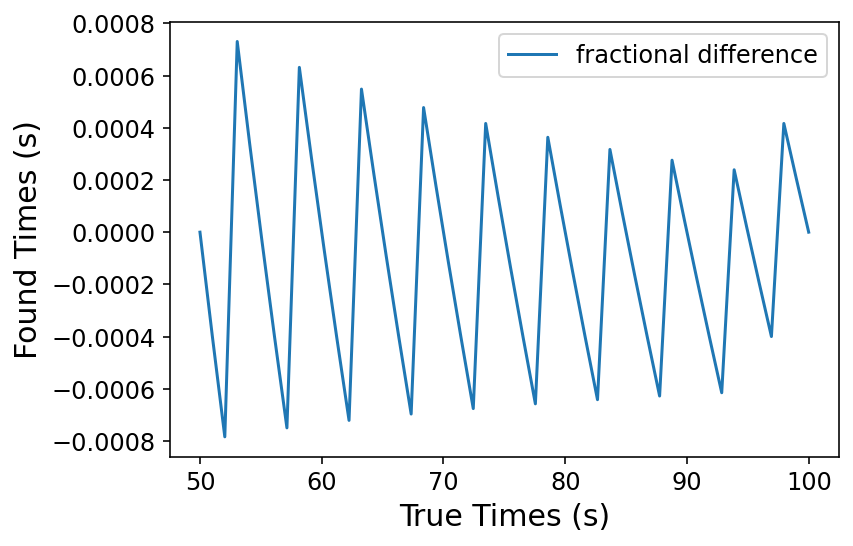

In [20]:
#>>>PROBLEM: P2.1.3
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.

true_times = np.linspace(50, 100, 50)
xi = np.arange(0, 128, SAMPLE_SPACING)
yi_noise = generate_noise(xi)

plt.plot(true_times, get_max_times(xi, yi_noise, true_times,iCheck=True), label = 'naive model')

plt.plot(true_times, true_times, label='perfect moel')

plt.xlabel('True Times (s)')
plt.ylabel('Found Times (s)')
plt.legend()
plt.show()

plt.plot(
    true_times,
    (get_max_times(xi, yi_noise, true_times,iCheck=True) - true_times)/true_times,
    label='fractional difference',
)
plt.xlabel('True Times (s)')
plt.ylabel('Found Times (s)')
plt.legend()
plt.show()

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 2.1.4</span>

Finally, let's make the problem more challenging by scaling the injected merger signal down by a factor of 20. What happens to the crude method in this case? Select the best answer below:

- The crude method is an almost exact match to the ideal algorithm.

- The crude method largely underestimates the time at which the signal event occurs but occasionally gets close or overestimates.

- The crude method largely overestimates the time at which the signal event occurs but occasionally gets close or underestimates.

- The crude method always underestimates the time at which the signal event occurs.

- The crude method always overestimates the time at which the signal event occurs.

- The crude method almost never gets the right answer. 

- The crude method doesn't work at all.

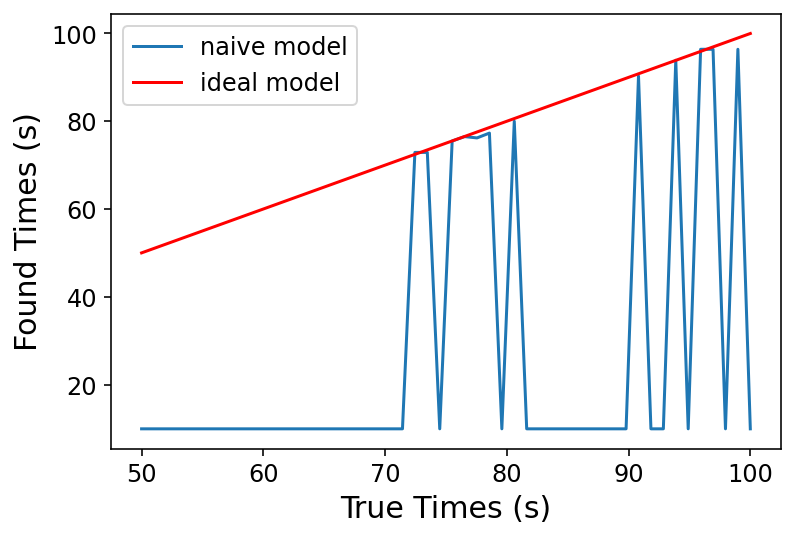

In [21]:
#>>>PROBLEM: P2.1.4
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.

true_times = np.linspace(50, 100, 50)
xi = np.arange(0, 128, SAMPLE_SPACING)
yi_noise = generate_noise(xi)

# Modify the following to scale the signal down by a factor of 20, compare the the ideal model
plt.plot(true_times, get_max_times(xi, yi_noise, true_times, scale=1/20), label = 'naive model')
plt.plot(true_times, true_times, color='red', label='ideal model')
plt.xlabel('True Times (s)')
plt.ylabel('Found Times (s)')
plt.legend()
plt.show()

<a name='section_6_2'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">P2.2 Fitting in the Time Domain: Part I</h2>    

| [Top](#section_6_0) | [Previous Section](#section_6_1) | [Problems](#problems_6_2) | [Next Section](#section_6_3) |


<h3>Overview</h3>

In the remaining questions below, you will continue investigating the process of extracting signal parameters using a more sophisticated algorithm, called matched filtering. Matched filtering in the time domain is one of the conceptually easiest examples of this technique. Specifically, we'll fit some noisy data with the actual merger signal function itself, with the goal of finding the time at which the signal event occurred. This is one of the more difficult problems of the course.

The whole procedure involves forcing the model function to assume a merger time of $t$ (this is the time of maximum amplitude, what we've called `TRUE_TIME`). Rather than trying to find a best fit value of $t$, we will simply scan across a range of values to extract the quality of the fit as a function of $t$. Ideally, we expect a very good fit quality when $t$ is close to the true time, and poor fits away from that value.

In the process of trying matched filtering, we'll also investigate how to determine the "quality" of a fit and, in particular, the impact of what we use for the uncertainties in the data.

An important limitation of the fits used below is that they only include the merger signal function itself. For now, we will not make any attempt to fit the noise terms that are added to the signal.

First, let's generate the data we will use in this process. Here, we return to the much simpler case where there are only 10 sinusoidal terms of added noise and the signal is not scaled down. As we saw before, simply finding the point of maximum amplitude in the total signal will indicate the merger signal true time quite reliably. We'll investigate how well matched filtering works at finding this true time.


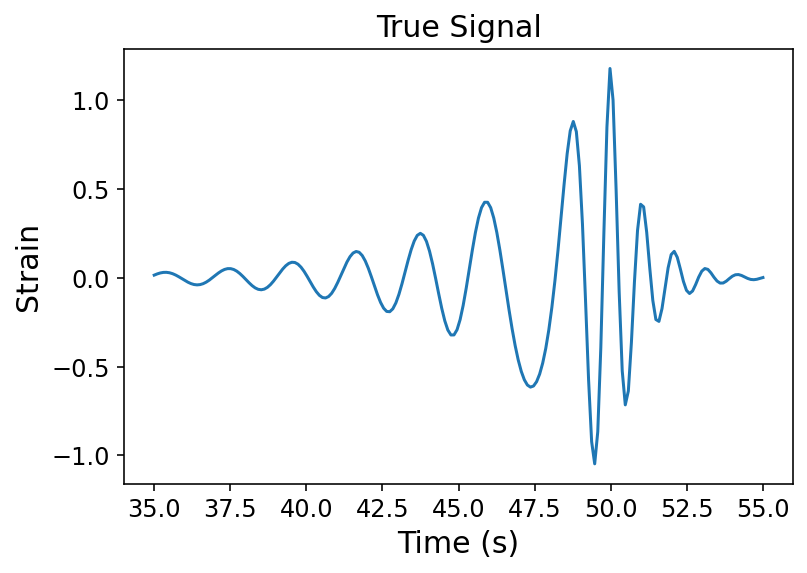

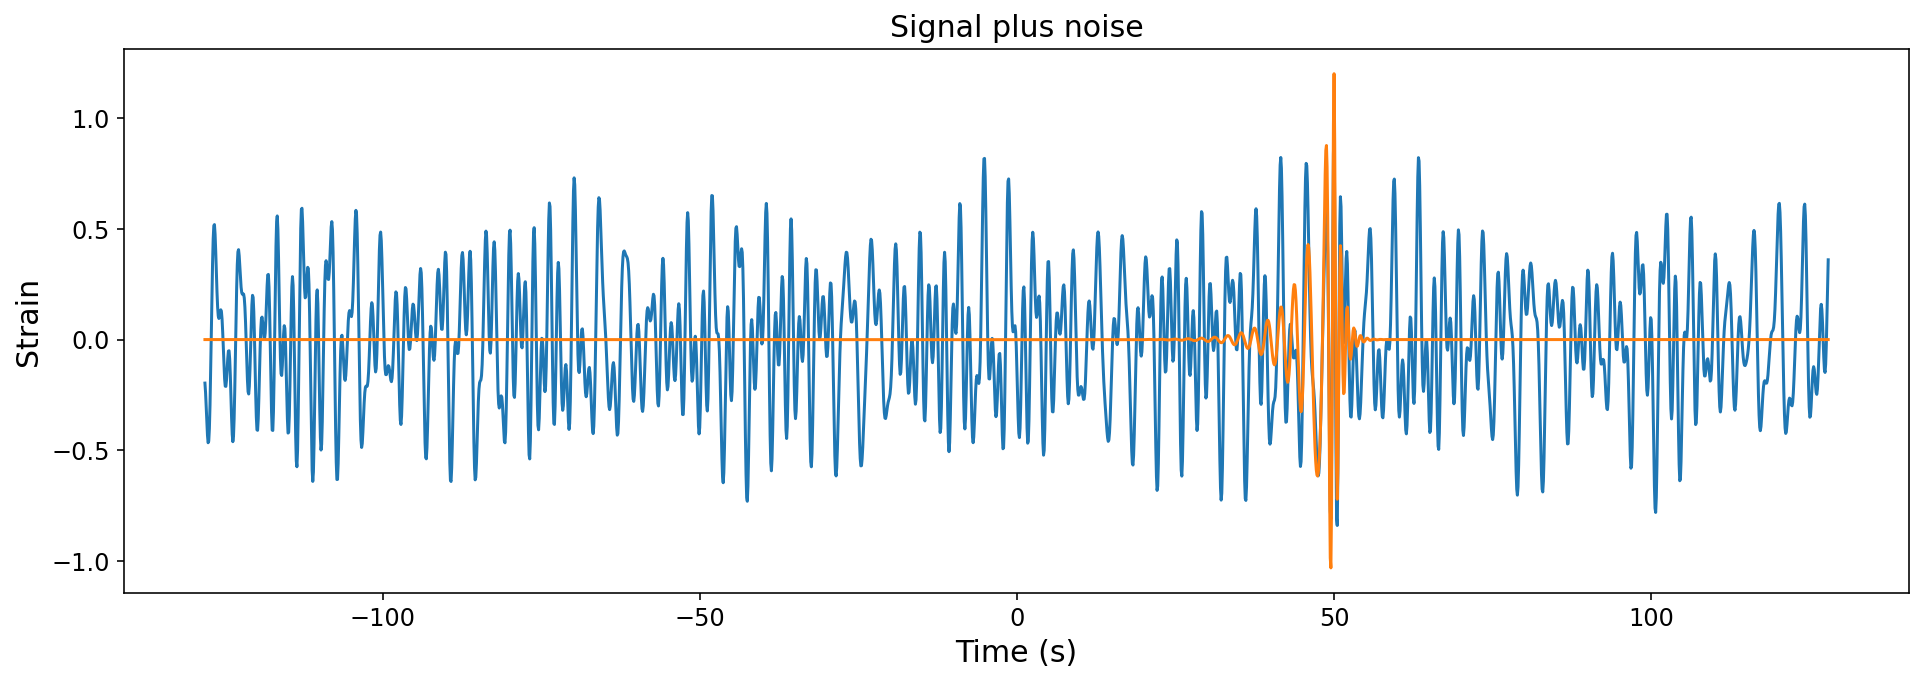

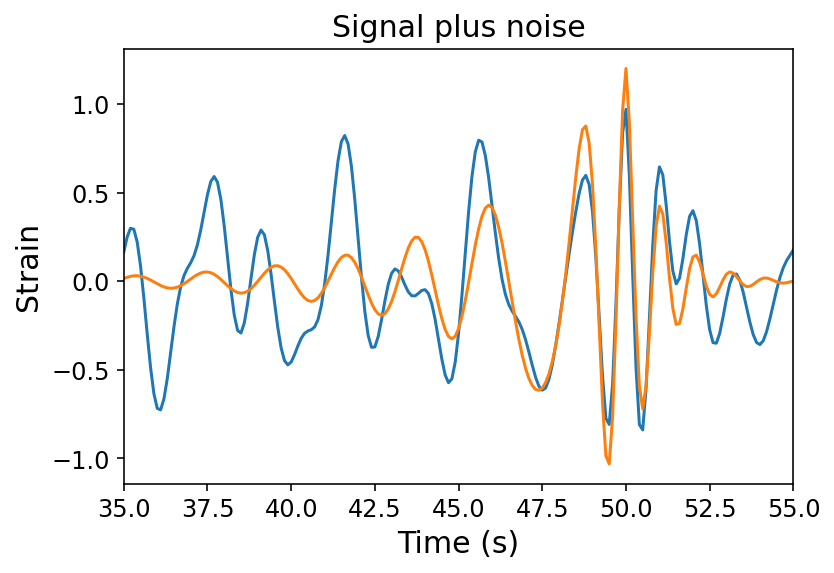

In [22]:
#>>>RUN: P2.2-runcell01

np.random.seed(0x98a09fe)

def complicated_model_fn(x, time, lambda_plus, lambda_minus, max_amp, omega_0, omega_max, omega_sigma):
    omega = (omega_max - omega_0) * (np.exp(-np.minimum(x - time, 0)**2 / omega_sigma)) + omega_0
    lambdas = np.array([lambda_plus if xvalue > time else lambda_minus for xvalue in x])
    amplitude = max_amp * np.exp(-abs(x - time) / lambdas)
    return amplitude * np.cos(omega * (x-time))


LAMBDA_PLUS_TRUE = 1.0
LAMBDA_MINUS_TRUE = 4
MAX_AMP_TRUE = 1.2
OMEGA_0_TRUE = 3.0
OMEGA_MAX_TRUE = 6.0
OMEGA_SIGMA_TRUE = 4.0
TIME_TRUE = 50.0

xi = np.linspace(TIME_TRUE-15, TIME_TRUE+5, 200)
yi_true = complicated_model_fn(xi, TIME_TRUE, LAMBDA_PLUS_TRUE, LAMBDA_MINUS_TRUE, MAX_AMP_TRUE,
                               OMEGA_0_TRUE, OMEGA_MAX_TRUE, OMEGA_SIGMA_TRUE)

NUMBER_SINES_TO_ADD = 10

noise_frequencies = 0.5 + 7 * np.random.random(NUMBER_SINES_TO_ADD)
noise_phases = 2 * np.pi * np.random.random(NUMBER_SINES_TO_ADD)
noise_amplitudes = 2 * MAX_AMP_TRUE / NUMBER_SINES_TO_ADD * np.random.random(NUMBER_SINES_TO_ADD)
    # The above line sets noise amplitudes so that the sum of all the noise amplitudes is on average
    # equal to the maximum amplitude of the signal.

plt.plot(xi, yi_true)
plt.title("True Signal")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.show()

sample_spacing = 0.1
xi = np.arange(-128, 128, sample_spacing)#times
yi = np.zeros_like(xi)#data

#Adding Noise
for freq, phase, amplitude in zip(noise_frequencies, noise_phases, noise_amplitudes):
    yi += amplitude * np.sin(phase + freq * xi)

#Adding Data
signal= complicated_model_fn(xi, TIME_TRUE, LAMBDA_PLUS_TRUE, LAMBDA_MINUS_TRUE, MAX_AMP_TRUE,
                               OMEGA_0_TRUE, OMEGA_MAX_TRUE, OMEGA_SIGMA_TRUE)
yi+=signal


plt.figure(figsize=(16, 5))
plt.plot(xi, yi)
plt.plot(xi, signal)
plt.title("Signal plus noise")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.show()

plt.plot(xi, yi)
plt.plot(xi, signal)
plt.title("Signal plus noise")
plt.xlim(35,55)
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.show()

<a name='problems_6_2'></a>     

| [Top](#section_6_0) | [Restart Section](#section_6_2) | [Next Section](#section_6_3) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 2.2.1</span>

Since the signal waveform has a limited extent before and after the time of maximum amplitude, it's clear that fitting all of the data with just the merger signal function will fail miserably. Rather, we'll need to select a subset of the data to perform the fit. How much time before and after the time of maximum signal $t$ do you think the fit should include? We really only need to consider the region where the signal is rather large and therefore will be more easily separated from the noise. In practice this is something we could find systematically, for example by analyzing the data close to and far from the maximum signal point. However, for now, read the guidance below to choose an appropriate window.

In what follows, only consider a 7-9 second long window, as this will include enough data to make our fits converge, but will still give few enough data points that the fits converge relatively fast. Furthermore, this window need not be symmetric around $t$, as much of the signal lies before the true time with only a short period of signal after $t$. Therefore, we want the number of earlier seconds to include (`t_before`) to be larger than the following time span (`t_after`).

With these conditions, one possible choice for `[t_before, t_after]` is `[5,2]`. What is another acceptable answer, given the constraints that we outlined?

Enter your answer as a list, formatted as `[t_before, t_after]`.

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 2.2.2</span>

In order to fit the signal waveform to a set of data, we need to write a function `model_and_random_parameters(t)` that creates an `lmfit` `Model` and associated `Parameters` for  `complicated_model_fn`. As discussed above, we want to force the time of the signal to appear at an input time `t`.  To limit the range that the fit considers, we also want to constrain the parameters, with limits in the dictionary `params_min_max`. the initial values of the parameters should be chosen randomly within those given ranges.

Complete the function `get_param_random_value` in the code below so that it choses random starting points for the parameters which are uniformly distributed between `p_min` and `p_max`.

To check if you've done this correctly, the lines at the end of the code print out the value of one of the parameters. With the given starting seed, the answer should be about 1.51. Test this in your notebook.

In [23]:
#>>>PROBLEM: P2.2.2
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.

from lmfit import Model, Parameters
    
    
def get_param_random_value(p_min,p_max):
    return np.random.uniform(p_min, p_max)


params_min_max = {
    'lambda_plus': (0.1, 5),
    'lambda_minus': (0.1, 5),
    'max_amp': (0, 2),
    'omega_0': (0, 5),
    'omega_max': (0, 10),
    'omega_sigma': (0, 5)
}

def model_and_random_parameters(t):
    model = Model(complicated_model_fn)
    params = Parameters()
    params.add('time', value=t, vary=False)
    for p, (p_min, p_max) in params_min_max.items():
        value = get_param_random_value(p_min,p_max)
        params.add(p, min=p_min, max=p_max, value=value)
    return model, params


#TEST EXAMPLE: SHOULD = 1.51166
t=0.1
np.random.seed(1)
print(model_and_random_parameters(t)[1].get('omega_0').value)

1.5116628631591988


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 2.2.3</span>

The code below includes a function `fit_once` that fits the model created in the previous problem and outputs the fit result. Remember that we only want to look at a limited subset of the data when we fit, namely the range `(t-t_before, t+t_after)`, where `t` is the specific time at which we want to look for the signal. This version uses the values `t_before = 5` and `t_after = 2`. 

You need to write a function `get_signal_indices` which returns the indices in the data arrays which correspond to this range of times. HINT: You may find the function `np.where()` useful.

Optionally print the $\chi^2$ result or the fit report. Note, that since a random seed is not defined, you may get different results each time you run. This is the point of choosing random initial parameters.

Fit chi2 value:  2.006692477667045
Fit chi2 probability:  1.0
[[Model]]
    Model(complicated_model_fn)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 170
    # data points      = 70
    # variables        = 6
    chi-square         = 2.00669248
    reduced chi-square = 0.03135457
    Akaike info crit   = -236.640519
    Bayesian info crit = -223.149547
    R-squared          = 0.87086836
[[Variables]]
    time:          50 (fixed)
    lambda_plus:   1.44948315 +/- 0.31231810 (21.55%) (init = 1.474176)
    lambda_minus:  4.99999999 +/- 1.41518126 (28.30%) (init = 3.967469)
    max_amp:       0.97546961 +/- 0.07577858 (7.77%) (init = 0.206452)
    omega_0:       2.85276410 +/- 0.04633459 (1.62%) (init = 2.239468)
    omega_max:     6.09395654 +/- 0.09941971 (1.63%) (init = 9.085955)
    omega_sigma:   4.48768771 +/- 0.31993850 (7.13%) (init = 1.468071)
[[Correlations]] (unreported correlations are < 0.100)
    C(lambda_minus, max_amp)     = +0.7467
    C(om

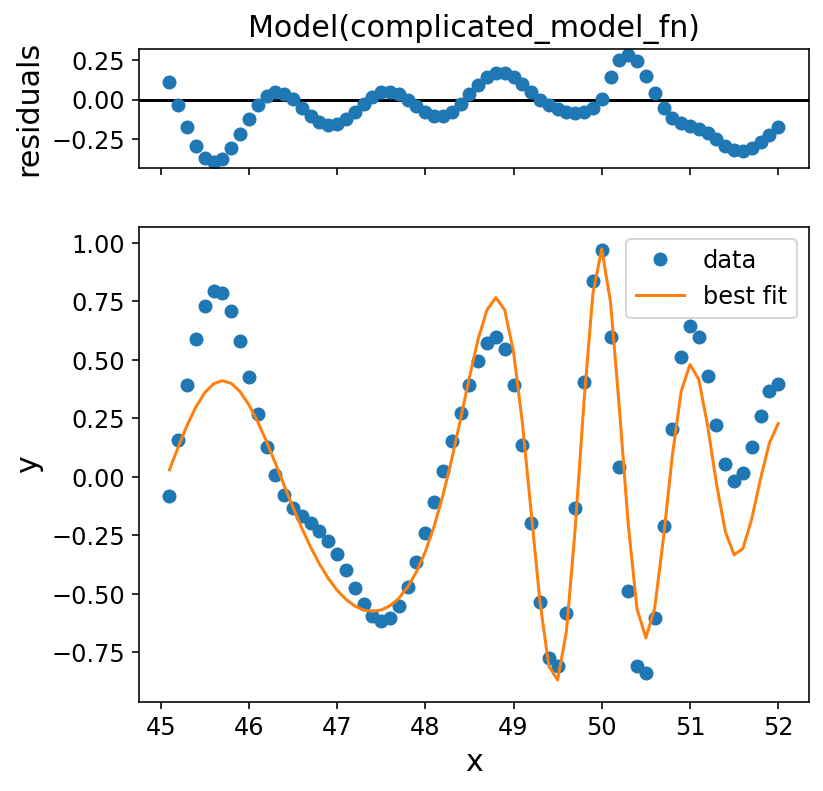

In [36]:
#>>>PROBLEM: P2.2.3
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.
import lmfit

#THE WINDOW MUST BE [5,2] FOR YOUR ANSWER TO MATCH EXPECTED VALUES
t_before = 5
t_after = 2


def get_signal_indices(xi, t, t_before, t_after):
    return np.where((xi > t - t_before) & (xi < t + t_after))

def fit_once(xi, yi, t, t_before, t_after):
    data_indices = get_signal_indices(xi, t, t_before, t_after)
    data_x = xi[data_indices]
    data_y = yi[data_indices]
    model, params = model_and_random_parameters(t)    
    result = model.fit(data_y, params, x=data_x)
    return result

result = fit_once(xi, yi, TIME_TRUE, t_before, t_after)
result.plot();

print("Fit chi2 value: ", result.chisqr)
print("Fit chi2 probability: ",1-stats.chi2.cdf(result.chisqr,result.nfree))
print(result.fit_report())

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 2.2.4</span>

Run the fit multiple times and print the $\chi^{2}$ value and $\chi^{2}$ probability using the following lines of code.

<pre>
print("Fit chi2 value: ", result.chisqr)
print("Fit chi2 probability: ",1-stats.chi2.cdf(result.chisqr,result.nfree))
</pre>

What is the lowest $\chi^{2}$ value that you obtain, and its corresponding $\chi^{2}$ probability?

Enter your answer as a list of numbers `[chi2, chi2_prob]` with precision 1e-3.

In [37]:
for i in range(10):
    result = fit_once(xi, yi, TIME_TRUE, t_before, t_after)

    print("Fit chi2 value: ", result.chisqr)
    print("Fit chi2 probability: ",1-stats.chi2.cdf(result.chisqr,result.nfree))

Fit chi2 value:  2.0066925761492564
Fit chi2 probability:  1.0
Fit chi2 value:  6.541258485676797
Fit chi2 probability:  1.0
Fit chi2 value:  2.8054031656158545
Fit chi2 probability:  1.0
Fit chi2 value:  2.006692487231908
Fit chi2 probability:  1.0
Fit chi2 value:  2.8054031539787205
Fit chi2 probability:  1.0
Fit chi2 value:  2.00669248788339
Fit chi2 probability:  1.0
Fit chi2 value:  2.0066924700978577
Fit chi2 probability:  1.0
Fit chi2 value:  2.0066924720408816
Fit chi2 probability:  1.0
Fit chi2 value:  6.541862209865357
Fit chi2 probability:  1.0
Fit chi2 value:  8.448622267694216
Fit chi2 probability:  1.0


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 2.2.5</span>


Let's consider whether the best $\chi^{2}$ value and its probability are reasonable numbers. In particular, what does the $\chi^{2}$ probability say about the fit? Choose the best answer from the following options:

- The fit is perfect! This is because our model is perfect. Our job is done.
- The fit is too perfect, which means we should carefully consider the assumptions we have made.
- The fit is okay, and we can do no better.
- The fit is terrible, so we should adjust our model or the range of data that we are fitting.


In [38]:
#>>>PROBLEM: P2.2.5
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.
import scipy.stats as stats

print("Fit chi2 probability: ",1-stats.chi2.cdf(result.chisqr,result.nfree))

Fit chi2 probability:  1.0


<a name='section_6_3'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">P2.3 Fitting in the Time Domain: Part II</h2>    

| [Top](#section_6_0) | [Previous Section](#section_6_2) | [Problems](#problems_6_3) | [Next Section](#section_6_4) |


<h3>Weighted Fitting</h3>

Our result for the fit in the previous questions suggests that the uncertainties are overestimated, but why? The real issue is that our fit so far has not taken into account the uncertainties correctly. To do that, we need to do a weighed $\chi^{2}$ fit.


<a name='problems_6_3'></a>     

| [Top](#section_6_0) | [Restart Section](#section_6_3) | [Next Section](#section_6_4) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 2.3.1</span>

We want to modify the previous fit to use uncertainties with a value of $\sigma=0.2$. To do this, you will run a "weighted" fit with `lmfit` by setting an array of weights. The code below is similar to what you saw above, but now with a function `fit_once_weighted`. You need to complete that function to use $\sigma=0.2$.

Note, the weights in `lmfit` are designed so that $w=1/\sigma$, leading to the following:

$$\chi^{2} = \sum_{i}\frac{(f(x_{i})-f(x))^{2}}{\sigma_{i}^{2}}$$

With this new version of the fit, what is the $\chi^{2}$ probability corresponding to the lowest $\chi^{2}$ value ? Enter your answer as a number with precision 1e-3.

Hint: As before, you can run the code multiple times or use a `for` loop.


Fit chi2 value:  169.05845395615952
Fit chi2 probability:  2.02118322079059e-11


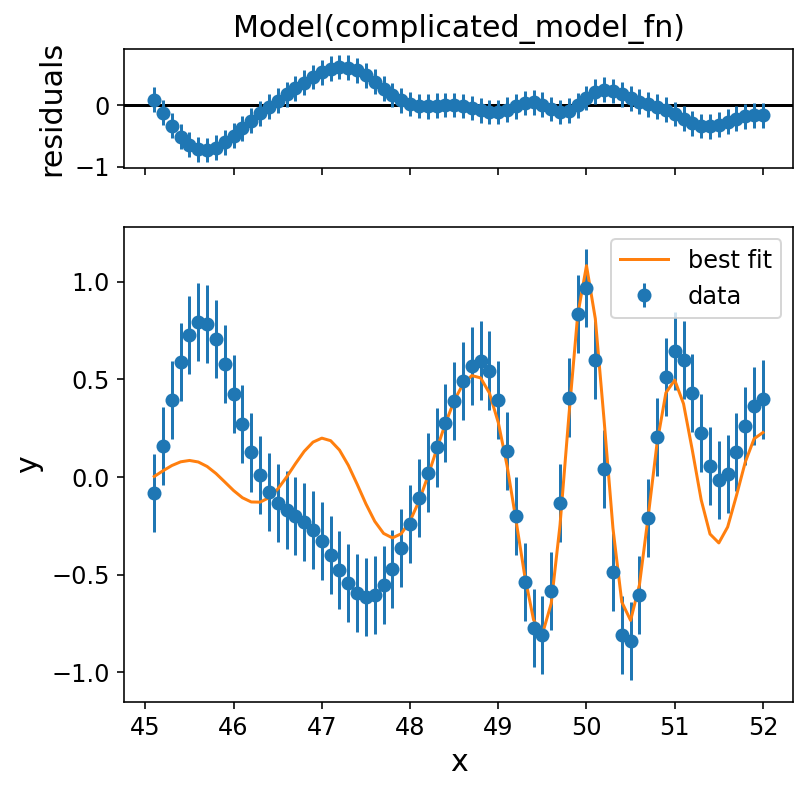

In [42]:
#>>>PROBLEM: P2.3.1
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.
import lmfit

def fit_once_weighted(xi, yi, t, t_before, t_after, weight=1.0):
    data_indices = get_signal_indices(xi, t, t_before, t_after)
    data_x = xi[data_indices]
    data_y = yi[data_indices]
    
    weights = np.repeat(weight, data_x.shape[0])
    
    model, params = model_and_random_parameters(t)
    result = model.fit(data_y, params, x=data_x,weights=weights)
    return result

#The window must be [5,2] for your answer to match expected values
t_before = 5
t_after = 2

unc=0.2
result = fit_once_weighted(xi, yi, TIME_TRUE, t_before, t_after,1./unc)

result.plot();
print("Fit chi2 value: ", result.chisqr)
print("Fit chi2 probability: ",1-stats.chi2.cdf(result.chisqr,result.nfree))

In [44]:
for _ in range(20):
    result = fit_once_weighted(xi, yi, TIME_TRUE, t_before, t_after,1./unc)
    print("Fit chi2 value: ", result.chisqr)
    print("Fit chi2 probability: ",1-stats.chi2.cdf(result.chisqr,result.nfree))

Fit chi2 value:  169.05845442137894
Fit chi2 probability:  2.02118322079059e-11
Fit chi2 value:  169.05845400363413
Fit chi2 probability:  2.02118322079059e-11
Fit chi2 value:  169.05845424987032
Fit chi2 probability:  2.02118322079059e-11
Fit chi2 value:  50.16731172155738
Fit chi2 probability:  0.8968375532043722
Fit chi2 value:  383.72333961414057
Fit chi2 probability:  0.0
Fit chi2 value:  70.13507891470266
Fit chi2 probability:  0.2794876261737562
Fit chi2 value:  169.05845448708058
Fit chi2 probability:  2.02118322079059e-11
Fit chi2 value:  50.16731192330265
Fit chi2 probability:  0.8968375494358237
Fit chi2 value:  50.167312233567685
Fit chi2 probability:  0.8968375436401541
Fit chi2 value:  70.13507898428882
Fit chi2 probability:  0.2794876242288602
Fit chi2 value:  169.05845396215264
Fit chi2 probability:  2.02118322079059e-11
Fit chi2 value:  169.0584543728211
Fit chi2 probability:  2.02118322079059e-11
Fit chi2 value:  50.16731176812738
Fit chi2 probability:  0.896837552334

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 2.3.2</span>

The choice of $\sigma=0.2$ in the previous problem was totally arbitrary. Can we come up with a strategy to compute a more realistic uncertainty for our data?  With LIGO data, this is a difficult question, since much of the wiggles from the "Noise" are actually understood as oscillations at certain frequencies. 

For now, we won't model the noise, but instead, we'll calculate uncertainties that reflect the average RMS of our noisy data by using a  signal-free region of time. 

The code below computes the standard deviation of the signal-free noise, but it needs to know what time range to use for that calculation. You need to complete the function `get_noise_indices` and then repeat the fit. In your noise calculation, only exclude the region that is considered in the fit.

What $\chi^{2}$ probability do you get, corresponding to the lowest $\chi^{2}$ value? Again, run your code multiple times to obtain the min value. Enter your answer **for the $\chi^{2}$ probability** as a number with precision 1e-3.

unc value:  0.47116721251295457
Fit chi2 value:  9.03921470131772
Fit chi2 probability:  1.0


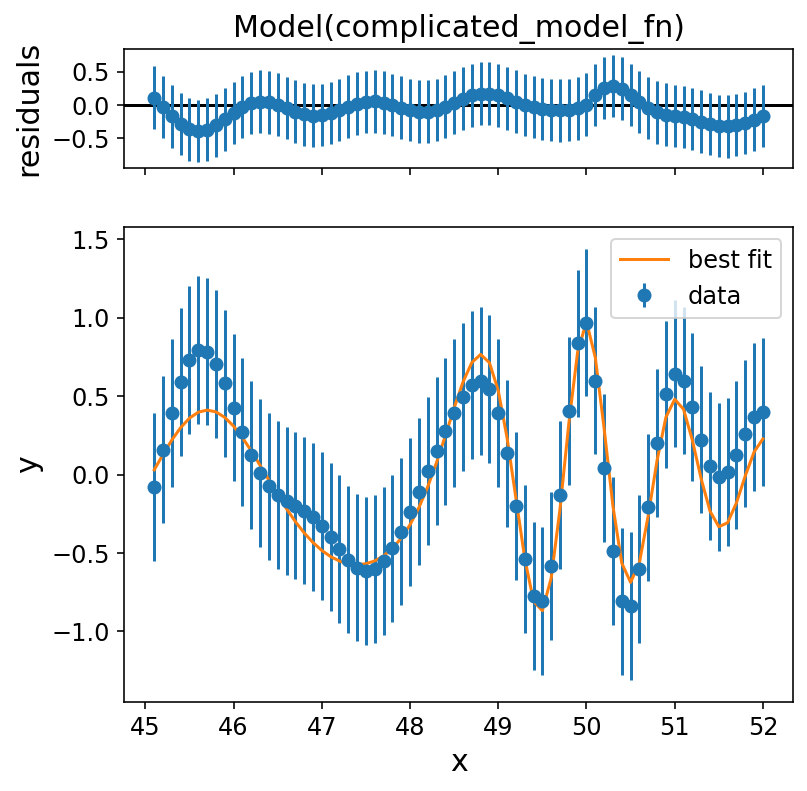

In [45]:
#>>>PROBLEM: P2.3.2
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.
import lmfit

def get_noise_indices(xi, t, t_before, t_after):
    return np.where((xi > t - t_before) & (xi < t + t_after))
    

def noise(xi, yi, t, t_before, t_after):
    data_indices = get_noise_indices(xi, t, t_before, t_after)
    data_y = yi[data_indices]
    return np.std(data_y)

t_before = 5
t_after = 2

unc=noise(xi, yi, TIME_TRUE, t_before, t_after)
result = fit_once_weighted(xi, yi, TIME_TRUE, t_before, t_after,1./unc)
result.plot();
print("unc value: ", unc)
print("Fit chi2 value: ", result.chisqr)
print("Fit chi2 probability: ",1-stats.chi2.cdf(result.chisqr,result.nfree))

In [46]:
for _ in range(10):
    unc=noise(xi, yi, TIME_TRUE, t_before, t_after)
    result = fit_once_weighted(xi, yi, TIME_TRUE, t_before, t_after,1./unc)
    print("Fit chi2 value: ", result.chisqr)
    print("Fit chi2 probability: ",1-stats.chi2.cdf(result.chisqr,result.nfree))

Fit chi2 value:  9.039214810994103
Fit chi2 probability:  1.0
Fit chi2 value:  9.03921462589304
Fit chi2 probability:  1.0
Fit chi2 value:  9.039214728886382
Fit chi2 probability:  1.0
Fit chi2 value:  9.03921466342548
Fit chi2 probability:  1.0
Fit chi2 value:  9.039214735189585
Fit chi2 probability:  1.0
Fit chi2 value:  9.039214673852278
Fit chi2 probability:  1.0
Fit chi2 value:  12.637041802798134
Fit chi2 probability:  0.9999999999996476
Fit chi2 value:  30.46118280590171
Fit chi2 probability:  0.9998817514232272
Fit chi2 value:  15.488842741136386
Fit chi2 probability:  0.9999999999398662
Fit chi2 value:  9.039214641531153
Fit chi2 probability:  1.0


<h3>Correlations</h3>

Our fit is, in some sense, still too good! Why is this the case? Well, what is happening in this case is that our fit is trying to match both the signal and the noise using a function that includes only the merger waveform. This is partly a feature of fitting time series data, where the noise causes the deviations of points from the signal waveform to be correlated with one another. For example, a point is very likely to be below the expected value if the previous point was low because the noise caused a downward fluctuation. This effect is quite obvious in the various residual plots. The calculation of $\chi^{2}$ in `lmfit` assumes that the data fluctuate randomly, with each point's deviation independent of the previous point.

To get a better estimate of the quality of the fit, we can imagine taking every other point or trying to compute the point to point variation, by taking the difference between consecutive points, or even points that are a little farther away. The larger the delta-t of our RMS, the less assumptions we are making about our ability to model background noise. 



<h3>Two Options for Addressing Correlations</h3>

Try running the cells below. In the first case, nearest-neighbor data are averaged and the data are fit again. In the second case, the noise is estimated from differences in points that are 2 time-steps away. Do you think these are reasonable attempts to account for the correlated nature of the data?


unc value:  0.45894062892242526
Fit chi2 value:  4.6428243831736
Fit chi2 probability:  0.9999999308048081


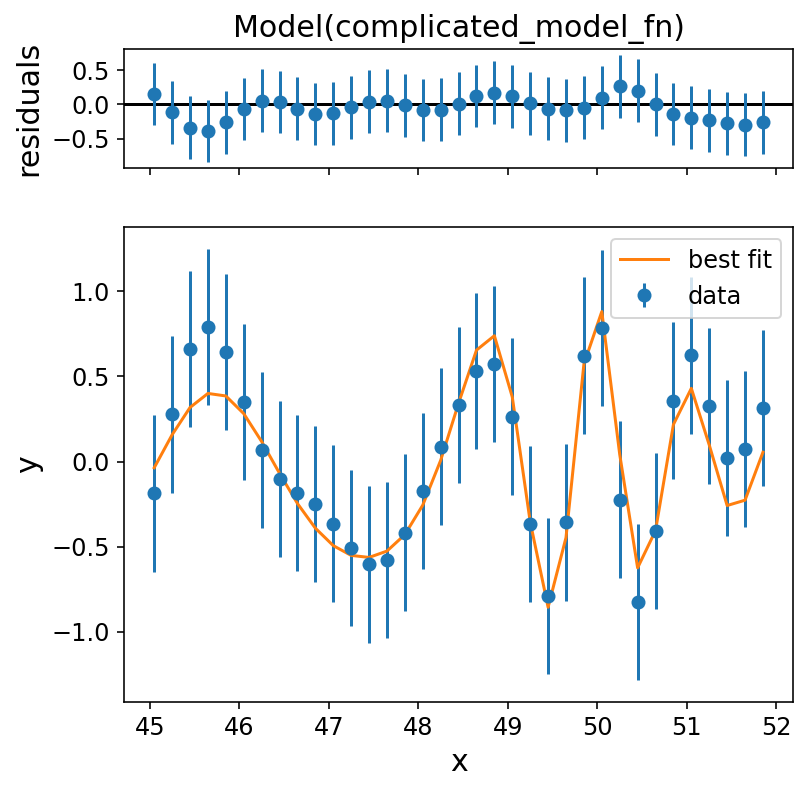

In [47]:
#>>>RUN: P2.3-runcell01

#Computing uncertainty: merging bins

xi_old = xi.copy()
yi_old = yi.copy()
xi_new = np.array([ 0.5*(xi_old[2*i]+xi_old[2*i+1]) for i in range(len(xi_old)//2) ])
yi_new = np.array([ 0.5*(yi_old[2*i]+yi_old[2*i+1]) for i in range(len(yi_old)//2) ])

t_before = 5
t_after = 2

uncout=noise(xi_new, yi_new, TIME_TRUE, t_before, t_after)
result = fit_once_weighted(xi_new, yi_new, TIME_TRUE, t_before, t_after,1./uncout)
result.plot();
print("unc value: ", uncout)
print("Fit chi2 value: ", result.chisqr)
print("Fit chi2 probability: ",1-stats.chi2.cdf(result.chisqr,result.nfree))

unc value:  0.40376380978467047
Fit chi2 value:  41.480320680086486
Fit chi2 probability:  0.9870282553121313


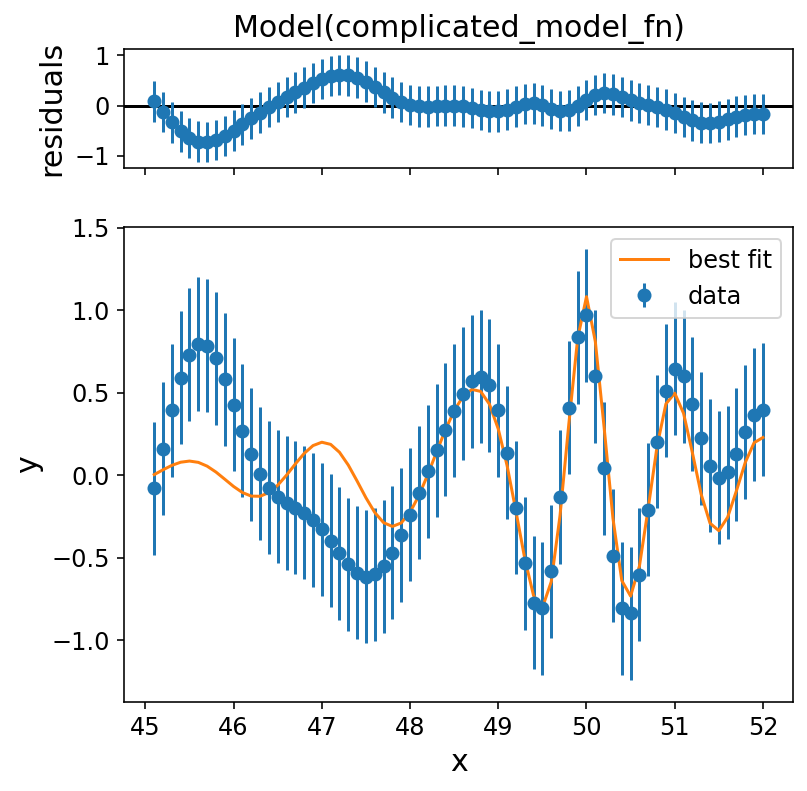

In [48]:
#>>>RUN: P2.3-runcell02

#Computing uncertainty: points 2 samples away

def noise_deltat(xi, yi, t, t_before, t_after, dt=2):#dt is the size distance of the samples
    data_indices = get_noise_indices(xi, t, t_before, t_after)
    #print(data_indices[0][:-dt],data_indices[0][dt:])
    data_y = yi[data_indices[0][:-dt]]-yi[data_indices[0][dt:]]
    return np.std(data_y)

t_before = 5
t_after = 2

uncout=noise_deltat(xi_old, yi_old, TIME_TRUE, t_before, t_after)
result = fit_once_weighted(xi_old, yi_old, TIME_TRUE, t_before, t_after,1./uncout)
result.plot();
print("unc value: ", uncout)
print("Fit chi2 value: ", result.chisqr)
print("Fit chi2 probability: ",1-stats.chi2.cdf(result.chisqr,result.nfree))

<a name='section_6_4'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">P2.4 Sweeping the Time Window</h2>   

| [Top](#section_6_0) | [Previous Section](#section_6_3) | [Problems](#problems_6_4) | [Next Section](#section_7_1) |


<h3>Overview</h3>

From the analysis above, we see that an uncertainty of 0.18 gave a more reasonable $\chi^2$ probability. This was found for `dt=2`, which should limit the assumptions we are making about the nature of the background noise.

Let's redefine `fit_once` using this uncertainty. Run the code below several times. Does it always find the lowest $\chi^2$ value?


Fit chi2 value:  61.93495296179037
Fit chi2 probability:  0.5498958915615527


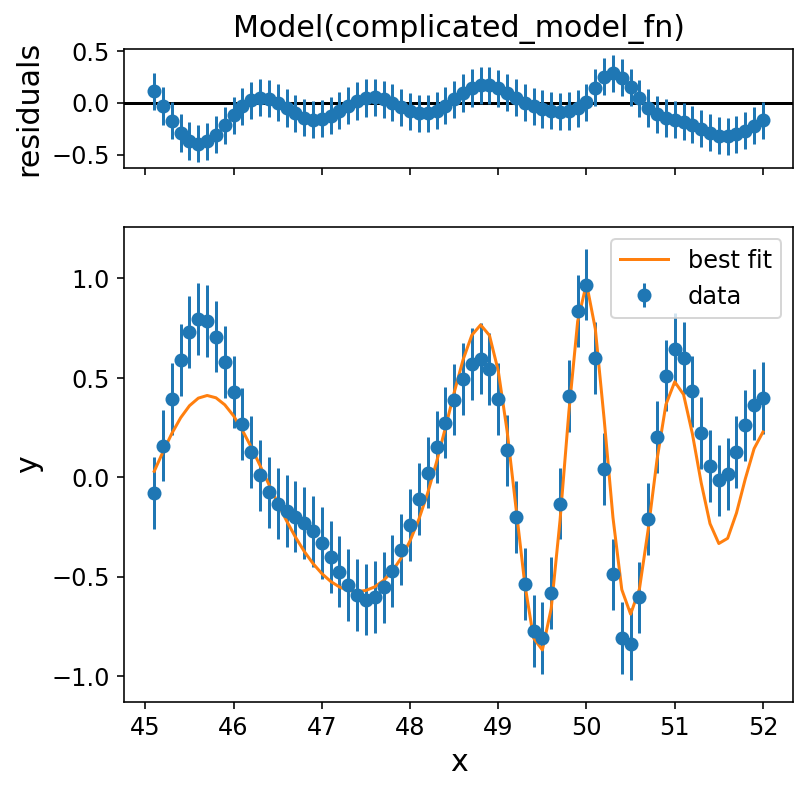

In [49]:
#>>>RUN: P2.4-runcell01

#From the above analysis, we see that an uncertainty of 0.18 is more reasonable.
#This was found for deltat = 2, which should limit that assumptions we are making
#about the nature of the background noise

#Let's try using this uncertainty


def fit_once_new(t, t_before, t_after, weight=1.0):
    data_indices = get_signal_indices(xi, t, t_before, t_after)
    data_x = xi[data_indices]
    data_y = yi[data_indices]
    weights = np.ones(len(data_x))*weight
    model, params = model_and_random_parameters(t)
    result = model.fit(data_y, params, x=data_x,weights=weights)
    return result

t_before = 5
t_after = 2

unc=0.18
result = fit_once_new(TIME_TRUE, t_before, t_after, 1.0/unc)
result.plot();
print("Fit chi2 value: ", result.chisqr)
print("Fit chi2 probability: ",1-stats.chi2.cdf(result.chisqr,result.nfree))

We see that the function with a fixed uncertainty of 0.18 gets the lowest $\chi^2$ often, but not every time and, therefore, it's not guaranteed to find the best fit on the first try. So, instead of `fit_once_new`, we'll use a new function called `fit`, which runs `fit_once_new` multiple times and outputs the best (lowest $\chi^2$) result.

<a name='problems_6_4'></a>     

| [Top](#section_6_0) | [Restart Section](#section_6_4) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 2.4.1</span>

In the code below, the function `fit_once_new` from above is run multiple times. Complete the code to find the best result in the list and return it. Specifically, modify the `get_min_result` function. 

What is the lowest $\chi^2$ value and its corresponding probability? Enter your answer as a list of numbers `[chi2, chi2_prob]` with precision 1e-3.

Fit chi2 value:  61.93495286374596
Fit chi2 probability:  0.54989589506461


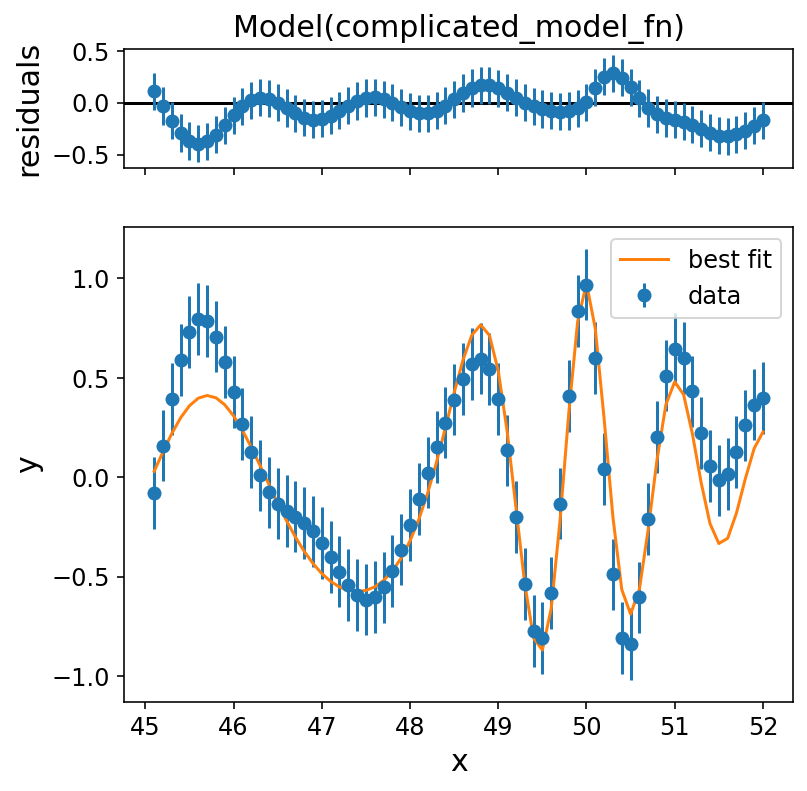

In [51]:
#>>>PROBLEM: P2.4.1
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.

def get_min_result(results):
    min_result = None
    min_chisq = None
    
    for result in results:
        if (min_result is None and min_chisq is None) or result.chisqr < min_chisq:
            min_result = result
            min_chisq = result.chisqr

    #for each result in results, set a new min_result and min_chisq
    #if result.chisqr is less than the currently stored value
    
    #YOUR CODE HERE
    
    return min_result

NUM_FITS = 10

def fit_many(t, t_before, t_after, weight, num):
    results=[]
    for i in range(num):
        results.append(fit_once_new(t, t_before, t_after, weight))

    min_result = get_min_result(results)
    return min_result

t_before = 5
t_after = 2
unc=0.18

min_result = fit_many(TIME_TRUE, t_before, t_after, 1.0/unc, NUM_FITS)

min_result.plot();
print("Fit chi2 value: ", min_result.chisqr)
print("Fit chi2 probability: ",1-stats.chi2.cdf(min_result.chisqr,min_result.nfree))

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 2.4.2</span>

Next, we want to see what the fits look like for different `t` values. The code cell below calls `fit_many` for values of $t \in [-100, 100]$, where the $t$ values are separated by $\Delta t = 1 \mathrm{s}$ and stores all of the fit outputs in an array named `results`. The code is complete, you just need to run it.

How long does it take to do this? (pick the closest answer)

A. .01 seconds

B. 1 second

C. 5 minutes

D. 5 hours (if this is the answer you pick **something is wrong**)

E. 10 days (if this is the answer you pick **something is wrong**)

In [54]:
%%time

results = []
delta_t = 1
ts = np.arange(-100, 100, delta_t)

t_before = 5
t_after = 2
unc=0.18

NUM_FITS = 6

for t in ts:
      if t % 20 == 0: print(t)
      results.append(fit_many(t, t_before, t_after, 1.0/unc, NUM_FITS))

-100
-80
-60
-40
-20
0
20
40
60
80
CPU times: user 1min 13s, sys: 269 ms, total: 1min 13s
Wall time: 1min 13s


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 2.4.3</span>

Now we need to find out for which $t$ value we get a fit that is most likely to be our signal. One way of figuring this out is by looking for which fit has the largest `max_amp` parameter, as the signal will have a higher max amplitude than the surrounding noise.

Plot `max_amp` as a function of $t$ given the `results` you just calculated. Find the value of $t$ which has the largest `max_amp` and plot the corresponding fit result.

Does the fit look like it could be the signal we're looking for? If yes, then enter below at what value of $t$ this was. If not, keep searching through the next highest `max_amp` values till you get something that may be signal and answer that $t$ value below.

Time of best fit result:  50


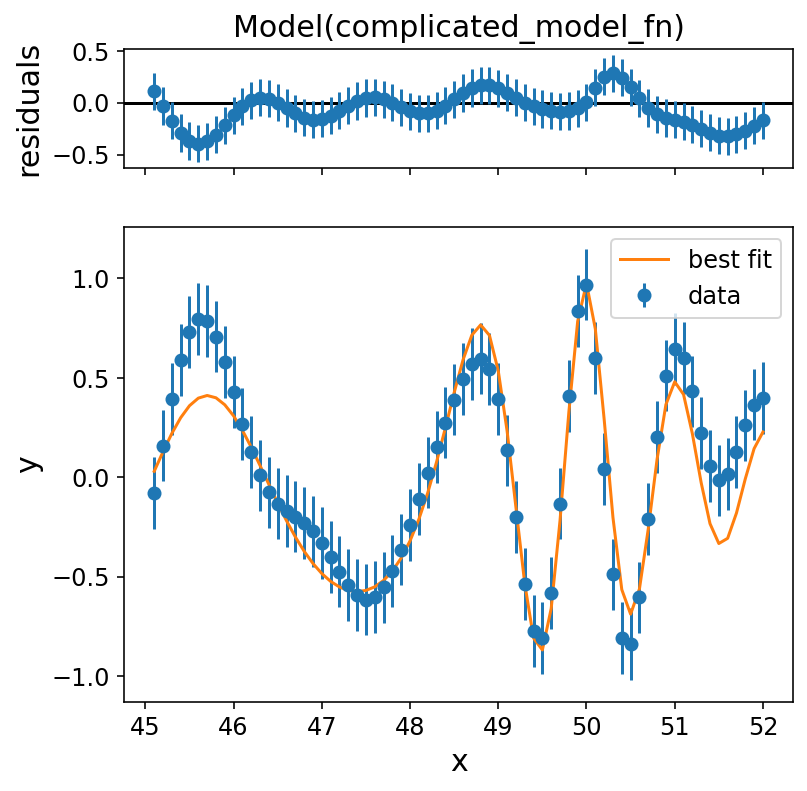

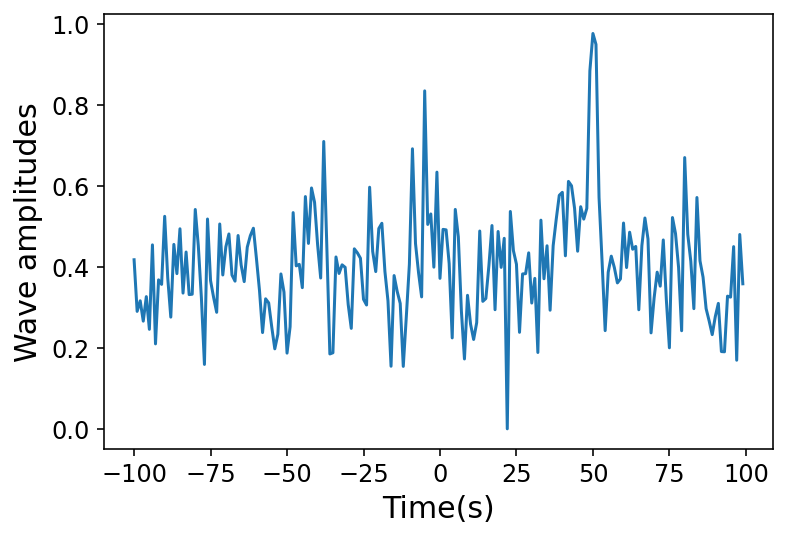

In [67]:
#>>>PROBLEM: P2.4.3
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.

amps = [result.params['max_amp'].value for result in results]
result_max_amp = results[np.argmax(amps)]

result_max_amp.plot()
print("Time of best fit result: ", ts[np.argmax(amps)])
plt.show()

plt.plot(ts, amps)
plt.xlabel("Time(s)")
plt.ylabel("Wave amplitudes")
plt.show()

<h3>Why Not Use the Minimum Chisq Value?</h3>

You might wonder why we chose to look for the maximum amplitude instead of the lowest $\chi^2$. The code shown below does the latter. Does the smallest chi-sq value give you the same t value that you found previously? Why or why not? What other criteria could you use to search for the signal?


Time of best fit result:  94  with lowest chi^2:  28.212736873167994


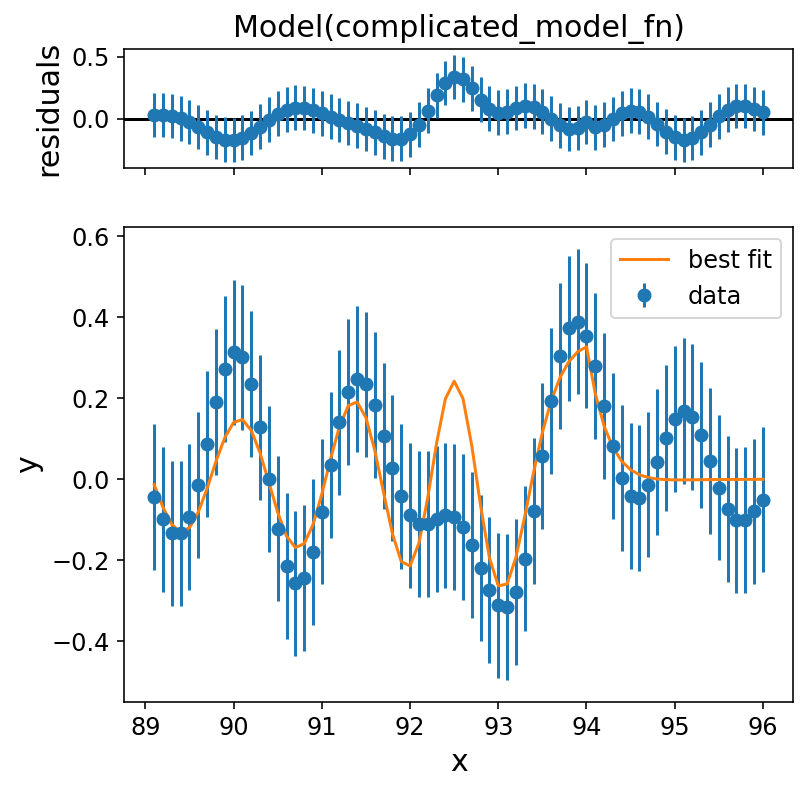

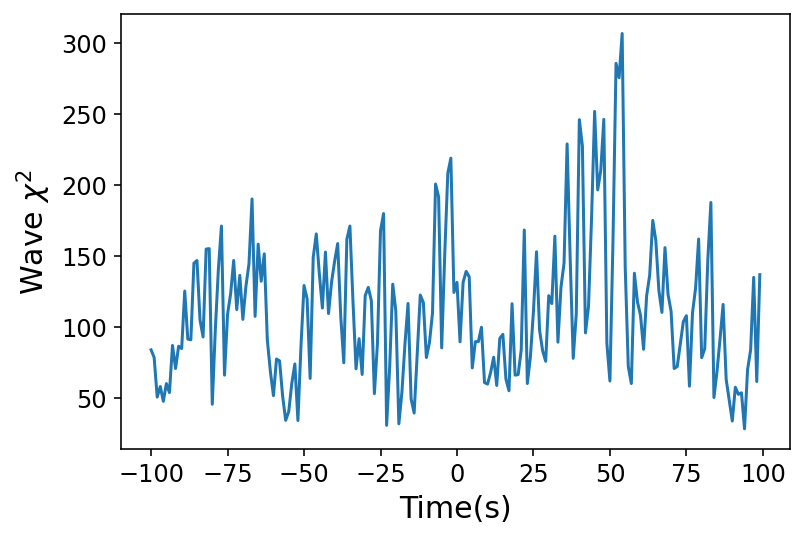

In [68]:
#>>>RUN: P2.4-runcell02

chi2 = [r.chisqr for r in results]
min_result=results[np.argmin(chi2)]
min_result.plot()
print("Time of best fit result: ", ts[np.argmin(chi2)]," with lowest chi^2: ",min_result.chisqr)
plt.show()

plt.plot(ts, chi2)
plt.xlabel("Time(s)")
plt.ylabel("Wave $\chi^{2}$")
plt.show()

As you can see, the fit with the minimum $\chi^2$ is not at the correct input signal time.

When we are fitting data, we are floating all the parameters of the fit, including amplitude. Our fit function is really quite complicated, so it's flexible enough to fit some areas of the noise.  Hence, low values of $\chi^{2}$ can occur in any area where the noise randomly matches enough aspects of the signal waveform to give a reasonable fit. As a result, there are many local minima and the global minimum turns out to be far away from the true signal time. 



<h3>How Can We Do Better?</h3>

This fit took a while to run and there doesn't seem to be an unambiguously ideal way to find the right answer in the array of results. In practice, it would be better for searches like this to run quickly and produce a more reliable answer, so that if a wave event is detected, an alert can be sent out to telescopes all over the world and they can look at the correct area of the sky with minimal delay. How could you make this process faster and more robust, aside from running it on better hardware?

Some options include:
    
- Constrain parameters of the model to realistic values so that you're fitting with fewer degrees of freedom
- Delve into the minimization software and tell it to halt if it's in a local minimum and not near the global minimum by checking if the chi-squared is unusually large. 
- Don't perform a full fit; compare to some template or set of templates and plot the chi squared



<h3> Moving Onward!</h3>

One possibility to explore is whether there is a better procedure that doesn't use the time domain! We will explore that next.    

<a name='section_7_1'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">P2.5 Introduction to Fitting in the Frequency Domain</h2>   

| [Top](#section_6_0) | [Previous Section](#section_6_4) | [Next Section](#section_7_2) |


<h3>Importing Data (Colab Only)</h3>

If you are in a Google Colab environment, run the cell below to import the data for this notebook. Otherwise, if you have downloaded the course repository, you do not have to run the cell below.

In [ ]:
#>>>RUN: P2.5-runcell000

!git init
!git remote add -f origin https://github.com/mitx-8s50/nb_LEARNER/
!git config core.sparseCheckout true
!echo 'data/P06' >> .git/info/sparse-checkout
!git pull origin main

<h3>Importing Libraries</h3>

Before beginning, run the cell below to import the relevant libraries for this notebook.

In [69]:
#>>>RUN: P2.5-runcell001

!pip install lmfit
!pip install playsound
!pip install soundfile


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
  Preparing metadata (setup.py) ... done
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7022 sha256=06095e2a37d991326b02125a452a34741e4d9f625336aa1cc5fe1c95ce26a3c6
  Stored in directory: /Users/Josh/Library/Caches/pip/wheels/50/98/42/62753a9e1fb97579a0ce2f84f7db4c21c09d03bb2091e6cef4
Successfully built playsound

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [70]:
#>>>RUN: P2.5-runcell002

import numpy as np                 #https://numpy.org/doc/stable/
import matplotlib.pyplot as plt    #https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html
from scipy.io.wavfile import write   #https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.write.html

from lmfit import Model, Parameters #https://lmfit.github.io/lmfit-py/parameters.html
                                    #https://lmfit.github.io/lmfit-py/model.html#lmfit.model.Model
import scipy.stats as stats         #https://docs.scipy.org/doc/scipy/reference/stats.html
from scipy.stats import chisquare   #https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html

<h3>Overview</h3>

**Note:** There are no problems in this section. Review and run the cells to understand later sections.

Previously, we studied the procedure of fitting in the time domain, including discovering some of its limitations. Now, we're going to do a similar process in the frequency domain. However, instead of performing a fit, we're going to compare the data to a template of a merger signal which we will generate.

Let's start by making the template in the time domain using the same function as before. The code below creates two sets of y values, one for the same parameters as before (`y_true`), and one with parameters that are similar to the true values but slightly shifted (`y_temp`). Note that the `y_temp` array uses a `TIME_TRUE` value of 0. In the plot, the time for the `y_true` array is shifted so that the two overlap.

In what follows, we will call the `y_true` array the "data" and the `y_temp` array the "template".

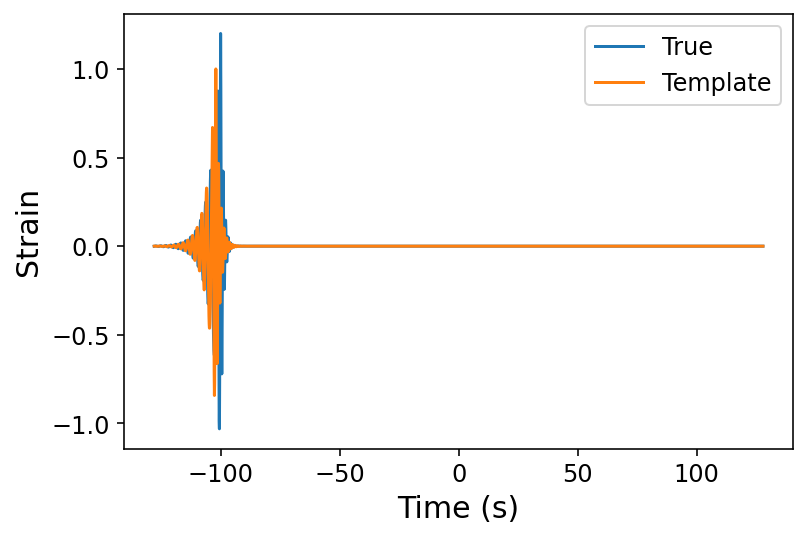

In [71]:
#>>>RUN: P2.5-runcell01

np.random.seed(0x98a09fe)

def complicated_model_fn(x, time, lambda_plus, lambda_minus, max_amp, omega_0, omega_max, omega_sigma):
    omega = (omega_max - omega_0) * (np.exp(-np.minimum(x - time, 0)**2 / omega_sigma)) + omega_0
    lambdas = np.array([lambda_plus if xvalue > time else lambda_minus for xvalue in x])
    amplitude = max_amp * np.exp(-abs(x - time) / lambdas)
    return amplitude * np.cos(omega * (x-time))

LAMBDA_PLUS_TRUE = 1.0
LAMBDA_MINUS_TRUE = 4
MAX_AMP_TRUE = 1.2
OMEGA_0_TRUE = 3.0
OMEGA_MAX_TRUE = 6.0
OMEGA_SIGMA_TRUE = 4.0
TIME_TRUE = 50.0
TIME_SHIFT = -150

sample_spacing = 0.1
xi       = np.arange(-128, 128, sample_spacing)#times
xi_shift = np.arange( -26, 230, sample_spacing)#times

yi_temp = complicated_model_fn(xi_shift, 0, 1.5, 3.5, 1.0, 3.2, 5.5, 3.5)
yi_true = complicated_model_fn(xi, TIME_TRUE+TIME_SHIFT, LAMBDA_PLUS_TRUE, LAMBDA_MINUS_TRUE, MAX_AMP_TRUE,
                               OMEGA_0_TRUE, OMEGA_MAX_TRUE, OMEGA_SIGMA_TRUE)

#Alternative approach
#template_mask = np.where((xi > -15) & (xi < 5))
#data_mask = np.where((xi > TIME_TRUE-15) & (xi < TIME_TRUE+5))#
#plt.plot(xi[data_mask]-TIME_TRUE, yi_true[data_mask], label="True")

template_mask = np.where((xi > -128) & (xi < 128))
data_mask     = np.where((xi > -128) & (xi < 128))
plt.plot(xi[data_mask], yi_true[data_mask], label="True")
plt.plot(xi[template_mask], yi_temp[template_mask], label="Template")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.legend();

In order to work in the frequency domain, we need to start by taking a Fourier transform of our template and data. Curiously, even though the two samples have an identical functional form, as well as very similar input parameters, the FFT outputs are very different, especially for the imaginary parts. As you can see in the 3rd plot, the real parts of the two FFTs also have some differences.

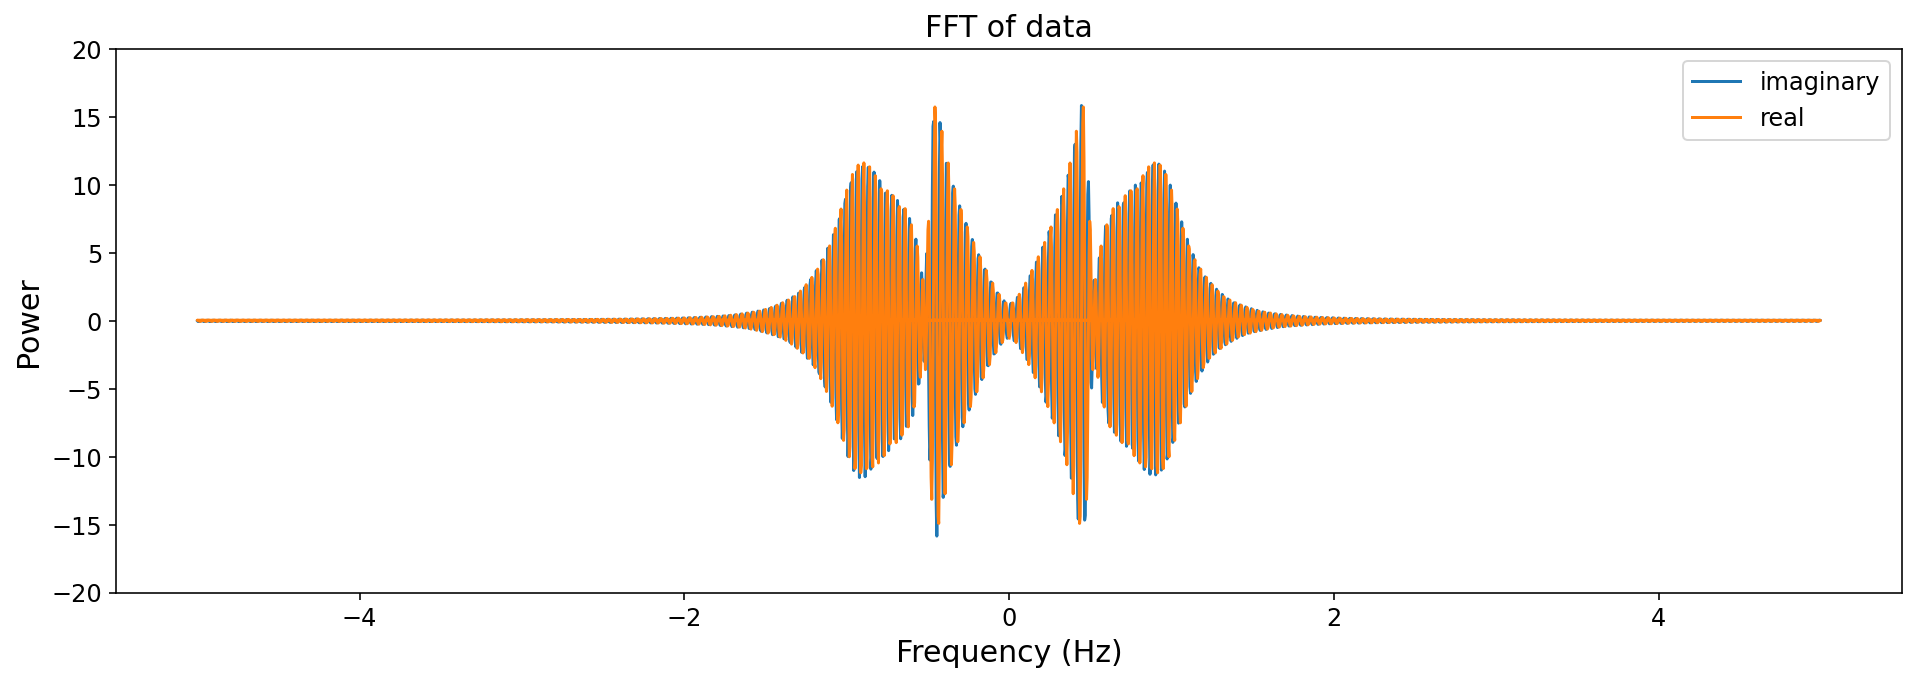

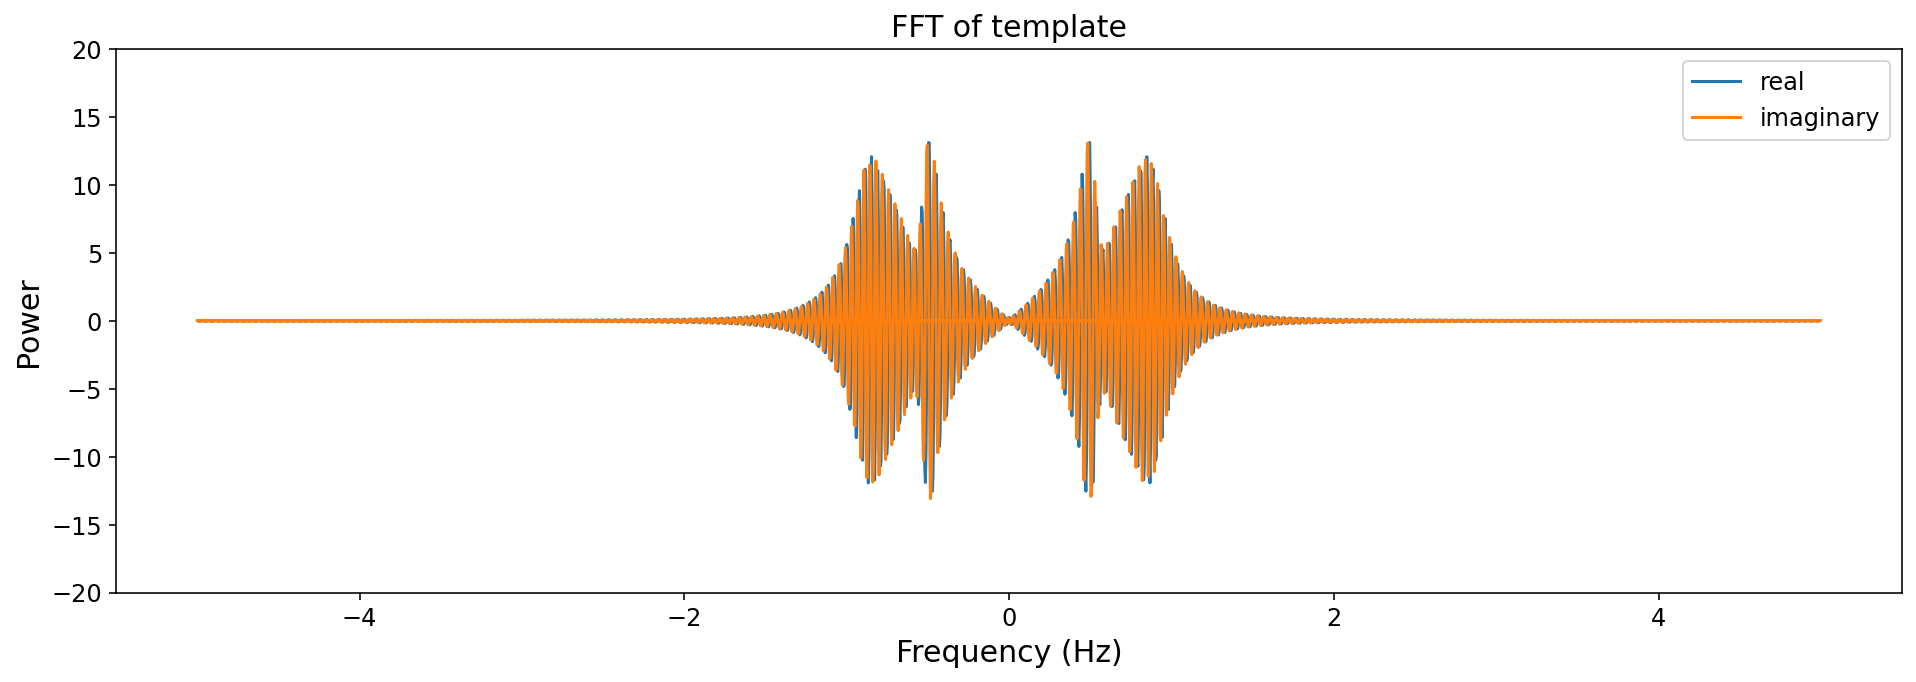

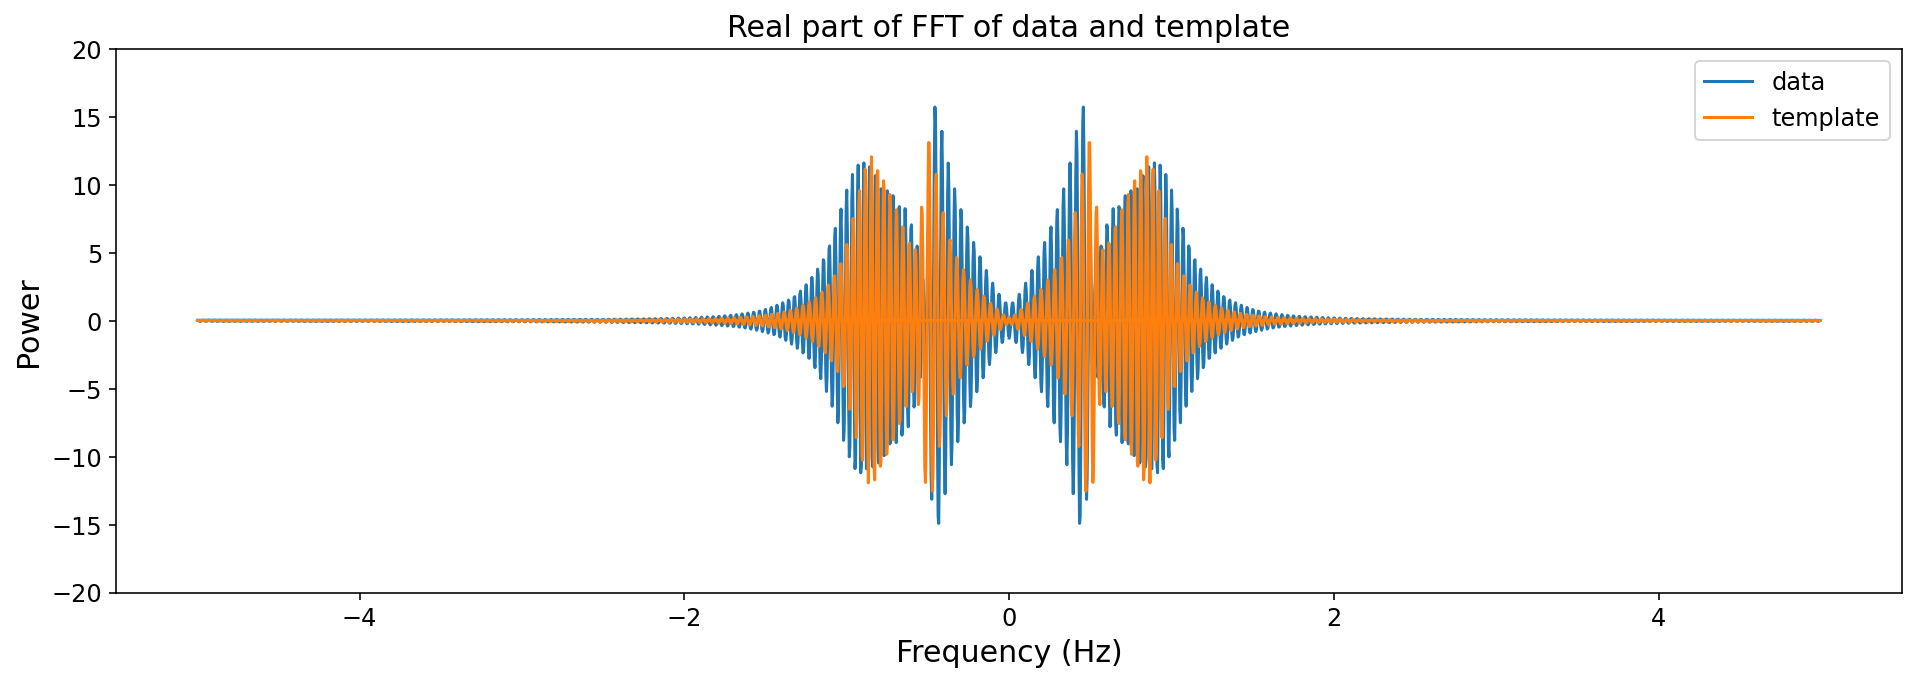

In [72]:
#>>>RUN: P2.5-runcell02

fs = int(1/(xi[1] - xi[0]))

data_fft = np.fft.fft(yi_true)
template_fft = np.fft.fft(yi_temp)

freq = np.fft.fftfreq(xi.shape[0])*fs

plt.figure(figsize=(16, 5))
plt.title("FFT of data")
plt.plot(freq, data_fft.imag, label='imaginary')
plt.plot(freq, data_fft.real, label='real')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.ylim(-20, 20)
plt.legend()
plt.show()

plt.figure(figsize=(16, 5))
plt.title("FFT of template")
plt.plot(freq, template_fft.real, label='real')
plt.plot(freq, template_fft.imag, label='imaginary')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.ylim(-20, 20)
plt.legend()
plt.show()

plt.figure(figsize=(16, 5))
plt.title("Real part of FFT of data and template")
plt.plot(freq, data_fft.real, label='data')
plt.plot(freq, template_fft.real, label='template')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.ylim(-20, 20)
plt.legend()
plt.show()


Now, suppose we want to do the same thing we did in the time domain case: shift the template by a time $t$. What happens to the FFT? Consider the integral definition of a Fourier transform (as a substitute for the discrete case):

$$\mathcal{F}(\omega) = \int dt f(t)  e^{-2\pi i\omega t}$$

So the FFT for a function shifted by $\Delta t$ is

$$\int dt f(t - \Delta t)  e^{-2\pi i\omega t} = \int dt' f(t')  e^{-2\pi i\omega (t'+\Delta t)} = e^{-2\pi i \omega \Delta t}\mathcal{F}(\omega).$$

The time-shifted FFT is just a constant multiplicative factor (albeit an imaginary number) times the initial template FFT!


So, suppose our data is indeed just our template, shifted by some time $\Delta t$. We can find $\Delta t$ from the data FFT $\mathcal{D}$ and the template FFT $\mathcal{T}$ using

$$\mathcal{D}(\omega)=e^{-2\pi i\omega \Delta t} \mathcal{T}(\omega) \implies \frac{\mathcal{D}(\omega)}{\mathcal{T}(\omega)}=e^{-2\pi i\omega \Delta t} = \frac{\mathcal{D}(\omega) \mathcal{T}^*(\omega)}{|\mathcal{T}|^2(\omega)}.$$

The inverse Fourier transform (IFFT) of the constant exponential factor is a delta function at $\Delta t$:

$$f(t) = \int d\omega e^{-2\pi i\omega \Delta t} e^{2\pi i\omega t} = \delta(\Delta t - t).$$

Consequently, the peak of the IFFT of 
$$f(\omega) =\mathcal{D}(\omega) \mathcal{T}^*(\omega)$$
must also be centered at $\Delta t$.

There are some extra complications involved here, but the discussion above gives the gist of what happens. For more in-depth information, see the <a href="https://www.gw-openscience.org/s/events/GW150914/LOSC_Event_tutorial_GW150914.html" target="_blank">LIGO tutorial from which this code is inspired</a>.

Let's compute $f(\omega)$ as given in the formula above. We call $f(\omega)$ `optimal_fft`. Then, we take the IFFT and call it `optimal_time`.

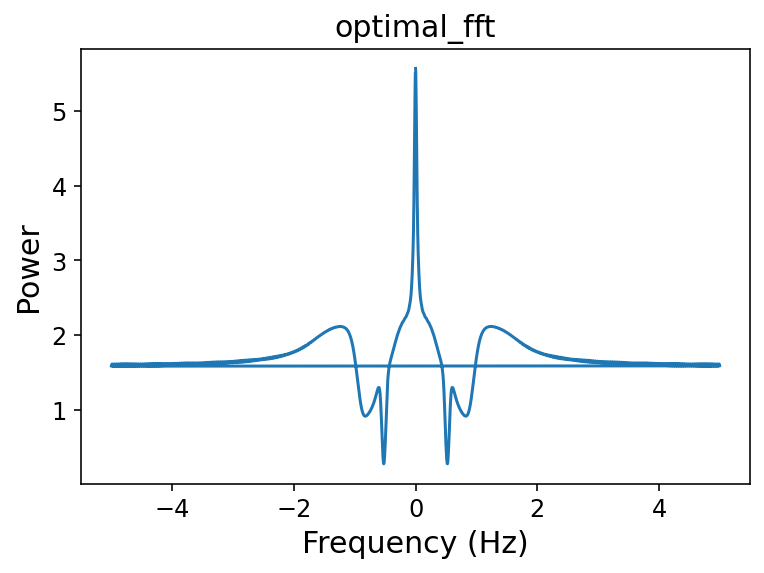

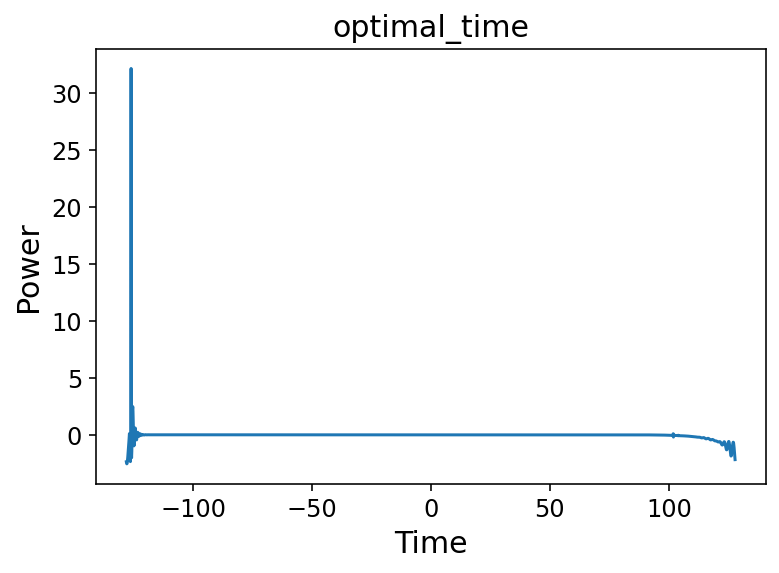

In [73]:
#>>>RUN: P2.5-runcell03

fftout=np.fft.fft(yi_temp)
optimal_fft = data_fft * template_fft.conjugate() / np.abs(fftout**2)
plt.plot(freq,np.abs(optimal_fft))
plt.title("optimal_fft")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.show()

#note the 2 is here b/c of the fft
optimal_time = 2*np.fft.ifft(optimal_fft)*fs
plt.plot(xi,optimal_time.real)
plt.title("optimal_time")
plt.xlabel("Time")
plt.ylabel("Power")
plt.show()

We should really plot some sort of signal to noise ratio, not `optimal_time` itself. Let's fix the ratio so that if the data is just noise, we have a ratio of one. We record the ratio as `SNR` and plot it.


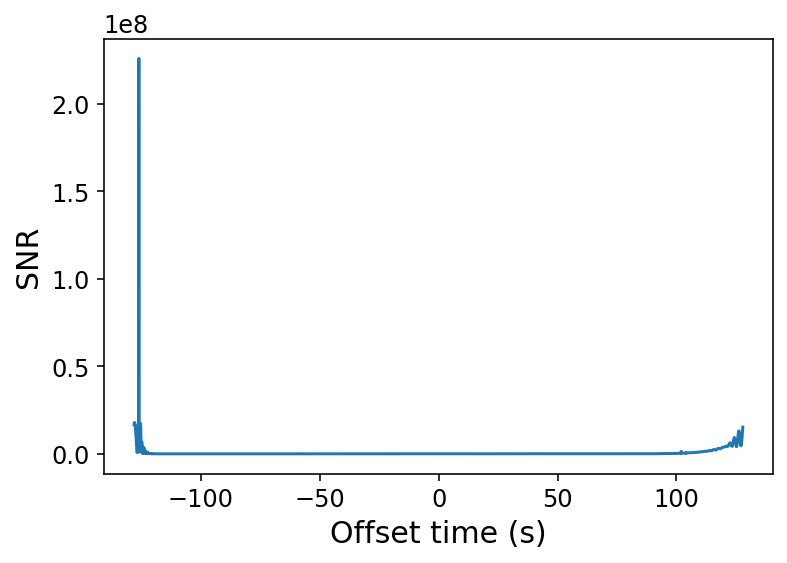

In [74]:
#>>>RUN: P2.5-runcell04

df = np.abs(freq[1] - freq[0])
#compute the resolution sigma^2=(|S|^2/PSD)*Delta t
sigmasq = 2*(template_fft * template_fft.conjugate() / fftout**2).sum() * df
sigma = np.sqrt(np.abs(sigmasq))
SNR = abs(optimal_time) / (sigma)

plt.figure()
plt.plot(xi, SNR)
plt.xlabel('Offset time (s)')
plt.ylabel('SNR');

<a name='section_7_2'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">P2.6 Analysis of Noisy Car Horn Data</h2>   

| [Top](#section_6_0) | [Previous Section](#section_7_1) | [Problems](#problems_7_2) | [Next Section](#section_7_3) |


<h3>Setup for Problems</h3>

In what follows, we will use a frequency based matched filtering algorithm to solve a different kind of problem. You will load two audio files: one containing a specific kind of car horn and another one containing street noise with this car horn sound inserted.

Note that there are several car horn sounds embedded in the street noise sample but, if executed correctly, the frequency based matched filtering should be able to find the specific car horn sound we are looking for!

983038 1161773
street_noise


None

car horn


None

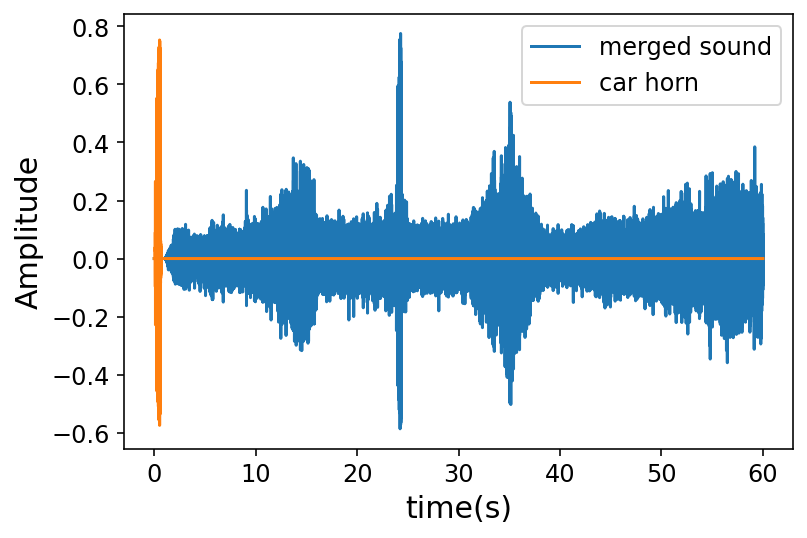

In [79]:
#>>>RUN: P2.6-runcell01

import soundfile as sf
import time
from IPython.display import Audio, display
import IPython

# Load the data into arrays
yi_true, fs = sf.read('data/P06/street_noise.wav') 
yi_temp, fs = sf.read('data/P06/car_horn.wav')
yi_true = yi_true[:,0]
yi_temp = yi_temp[:,0]

print(min,max)
#play these guys
min=int(22*(len(yi_true)/60))
max=int(26*(len(yi_true)/60))

def play(iArray,iFS):
    sf.write('data/P06/tmp.flac', iArray, iFS)
    IPython.display.display(display(Audio('data/P06/tmp.flac',autoplay=False)))

print("street_noise")
play(yi_true[min:max],fs)

print("car horn")
play(yi_temp,fs)

# Compresses the data to a smaller size by averaging 5 element chunks together
# Note that this does not change the data, just decreases its resolution
yi_true     = np.array(yi_true)
yi_true_avg = np.average(yi_true.reshape(-1, 5), axis=1)



# Make the template the same length as the signal by filling it with 0's
# This is needed for the fft analysis to work
yi_temp = np.concatenate((yi_temp, np.zeros(5*int(len(yi_temp)+1)-len(yi_temp))))
yi_temp_avg = np.average(yi_temp.reshape(-1, 5), axis=1)
yi_temp_avg = np.concatenate((yi_temp_avg, np.zeros(len(yi_true_avg)-len(yi_temp_avg))))


# Create time array, from 0 to 60 second (the length of the street noise recording)
# Time array also has the same resolution as the street noise, in order for fft analysis to work
xi = np.linspace(0, 60, len(yi_true_avg))

#Let's plot
plt.plot(xi,yi_true_avg,label='merged sound')
plt.plot(xi,yi_temp_avg,label='car horn')
plt.xlabel('time(s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

<a name='problems_7_2'></a>   

| [Top](#section_6_0) | [Restart Section](#section_7_2) | [Next Section](#section_7_3) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 2.6.1</span>

The code above loaded two datasets: one is a template containing the car horn and the other is true data containing car horn embedded into street noise. Using the same approach as in the previous section, first plot the real and imaginary parts of the FFT for both datasets. Also, plot the real parts of the FFT of the template compared to the noisy data. Fill in the missing code to accomplish this.

Consider the plots of the template and the data in the frequency domain. Which sound sample has a greater range of frequencies (a spectrum with power more broadly and continuously spread over frequency)?

A. Template

B. Data

C. They look very similar

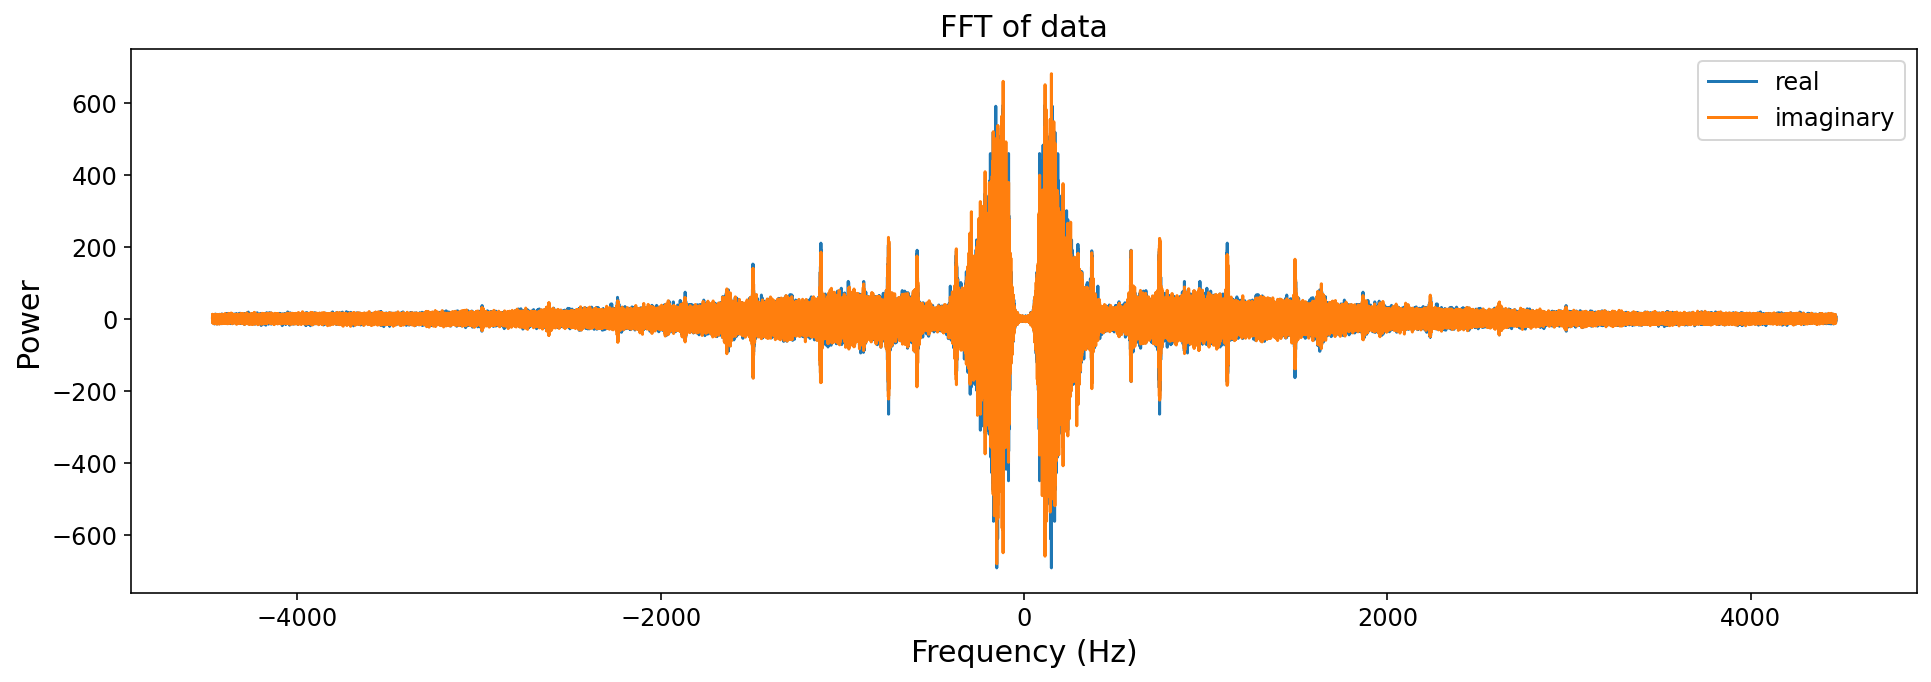

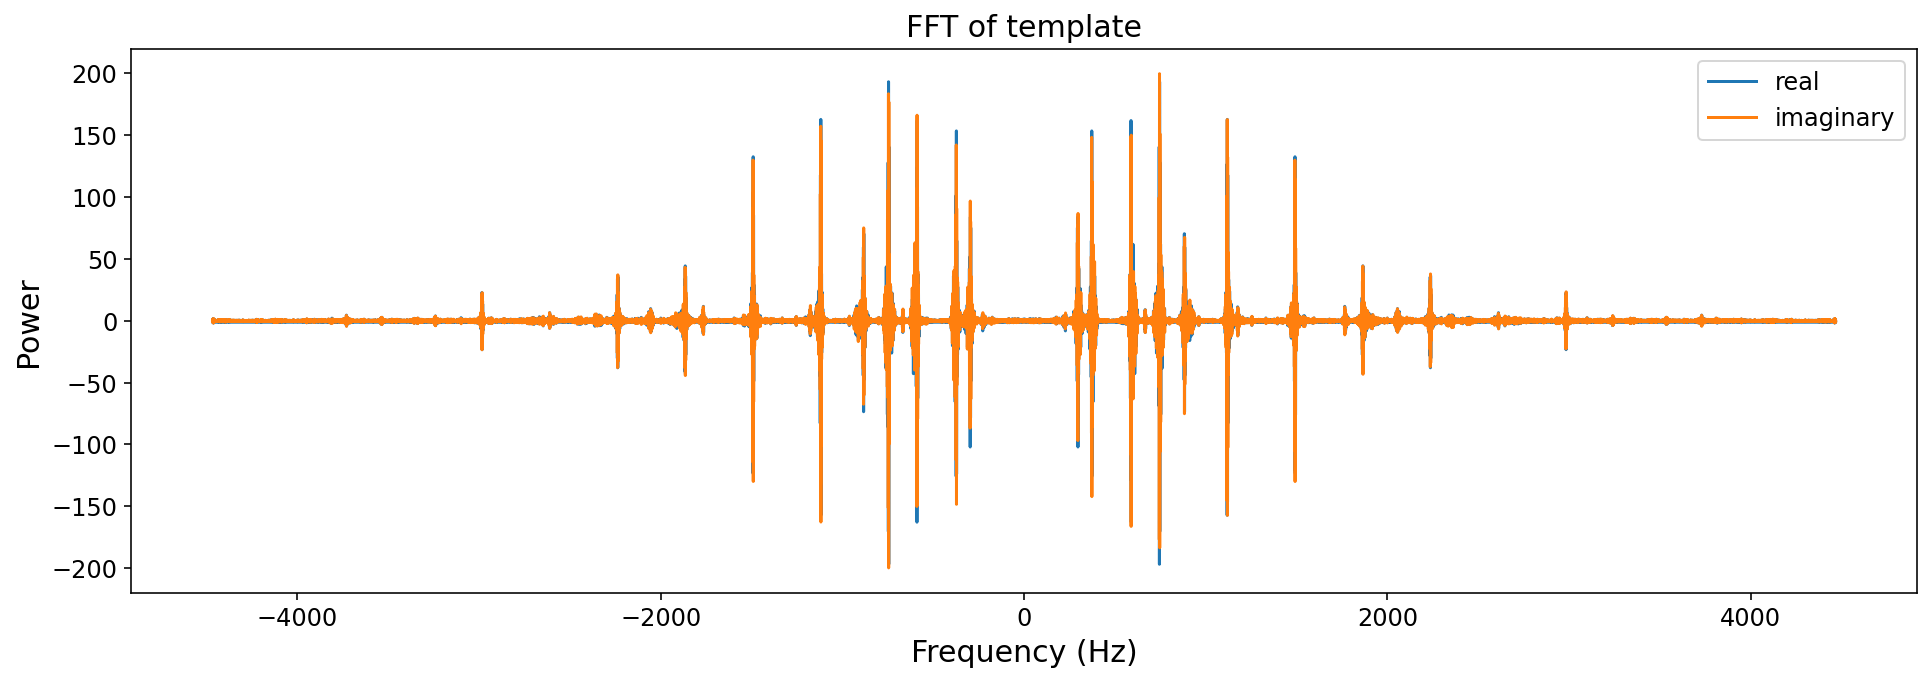

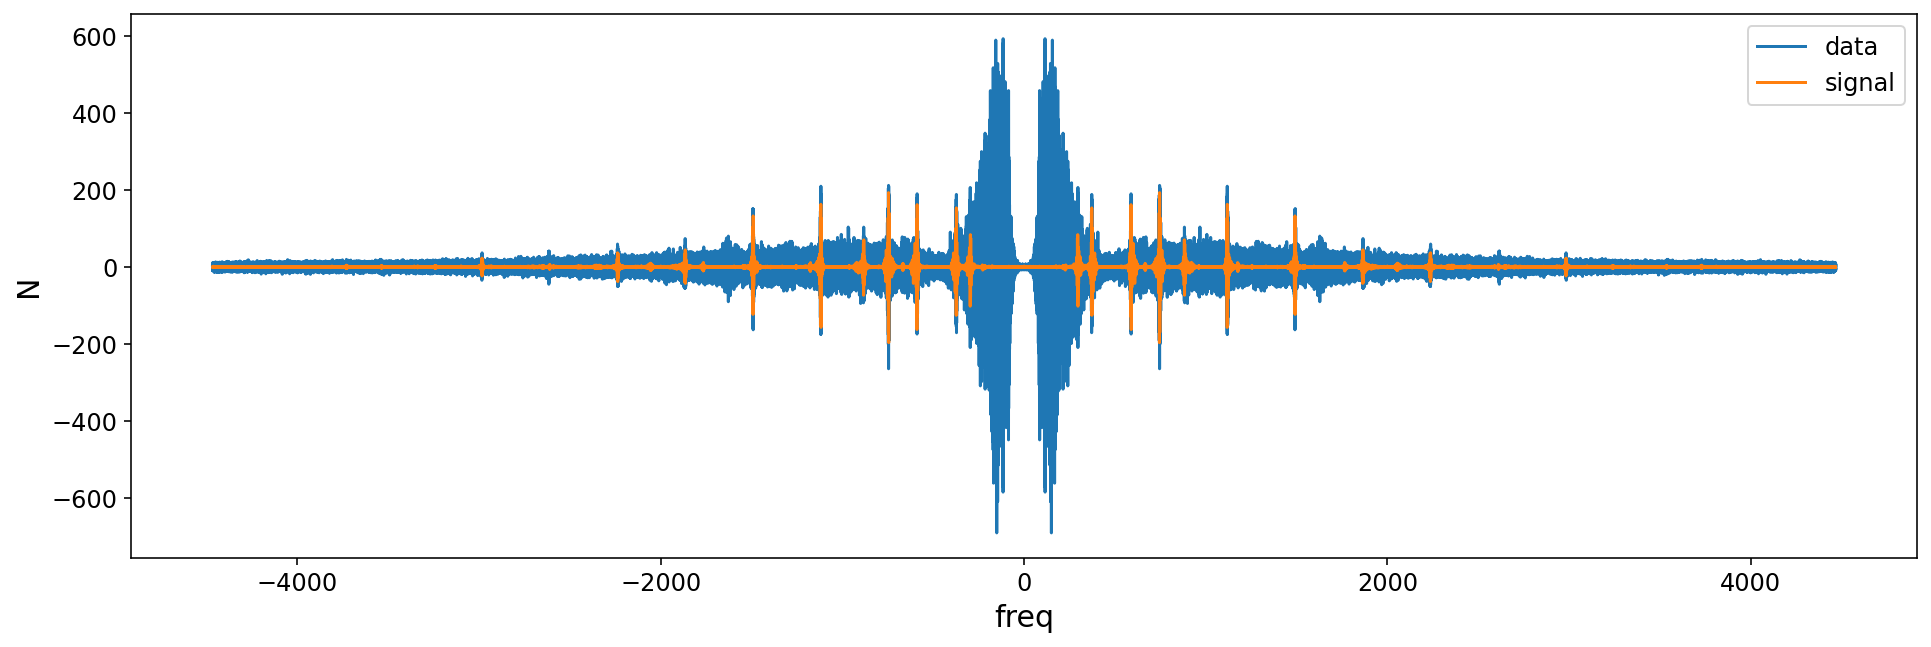

In [90]:
#>>>PROBLEM: P2.6.1
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.


#copy and paste the FFT
fs = int(1/(xi[1] - xi[0]))
data_fft = np.fft.fft(yi_true_avg)
template_fft = np.fft.fft(yi_temp_avg)
freq = np.fft.fftfreq(xi.shape[0])*fs


plt.figure(figsize=(16, 5))
plt.title("FFT of data")
plt.plot(freq, data_fft.real, label='real')
plt.plot(freq, data_fft.imag, label='imaginary')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
#plt.ylim(-20, 20)
plt.legend()
plt.show()

plt.figure(figsize=(16, 5))
plt.title("FFT of template")
plt.plot(freq, template_fft.real, label='real')
plt.plot(freq, template_fft.imag, label='imaginary')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
#plt.ylim(-20, 20)
plt.legend()
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(freq,data_fft.real,label='data')
plt.plot(freq,template_fft.real,label='signal')
plt.xlabel('freq')
plt.ylabel('N')
plt.legend()
plt.show()


>#### Follow-up 2.6.1a (ungraded)
>   
>Why does this answer make sense? Think about all the noise in the data that doesn't exist in the template.


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 2.6.2</span>

When looking at the FFT of the LIGO template shown earlier, there was a large difference between the real and imaginary parts of the frequency space. Is there a large difference in the real and imaginary parts of the car-horn template?


A. Yes

B. No


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 2.6.3</span>

At what frequency (in Hz) does the power spectral density (PSD) spectrum of the data distribution peak? Enter your answer as a number with precision 1 (i.e. the closest integer).

Hint: Take the absolute value of the FFT$^{2}$ of the data to get the PSD spectrum. Use the helpful command `np.argmax()` to find the index of the maximum element of the PSD. Use this index to find the frequency.

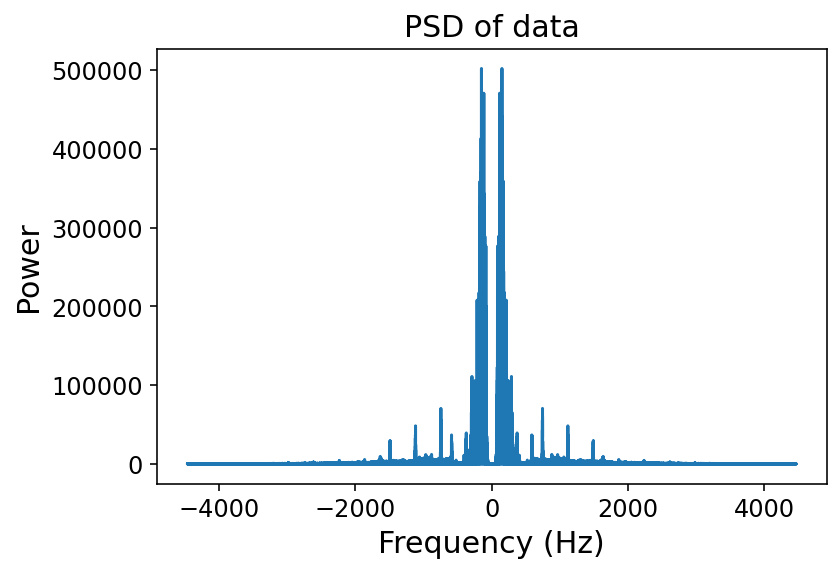

Frequency at which the PSD is at its maximum:  -150.42126955649263


In [92]:
#>>>PROBLEM: P2.6.3
freq_psd = np.abs(data_fft**2)
freq_psd_max = freq[np.argmax(freq_psd)]

plt.plot(freq,freq_psd,label='psd')
plt.title("PSD of data")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.show()
print("Frequency at which the PSD is at its maximum: ", freq_psd_max)

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 2.6.4</span>

At what time (in seconds) does the car horn signal modeled in the template occur in the data? Enter your answer as a number with precision 1e-1.

Hint: Follow the example from what was done in Section P7.1 to find the time shift between the LIGO signal template and the data. Again, use `np.argmax()` to find the index of the maximum element of the `SNR`, and find the corresponding element of the time data array.

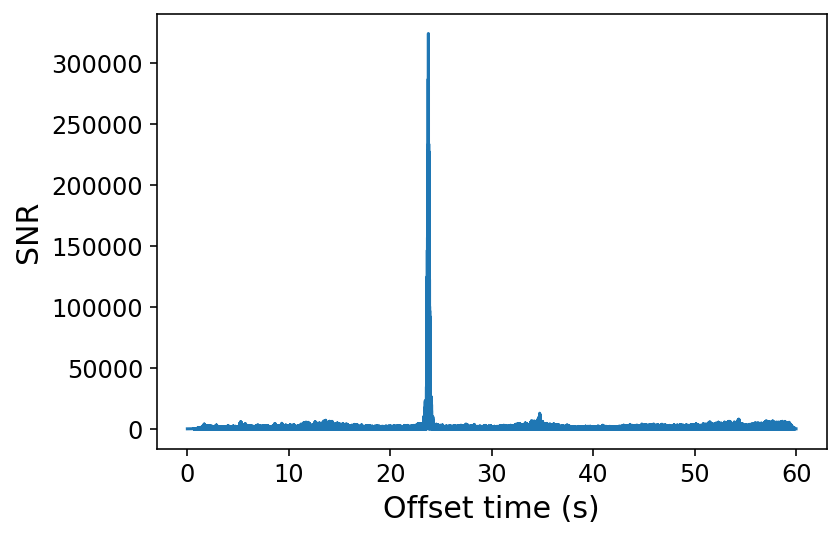

Time at which SNR peaks:  23.757427238242304


In [99]:
#>>>PROBLEM: P2.6.4

optimal_fft = data_fft * template_fft.conjugate()
optimal_time = 2*np.fft.ifft(optimal_fft)*fs

df = np.abs(freq[1] - freq[0])

sigmasq = 2*(template_fft * template_fft.conjugate() / template_fft**2).sum() * df
sigma = np.sqrt(np.abs(sigmasq))
SNR = abs(optimal_time) / (sigma)

time_SNR_max = xi[np.argmax(SNR)]

plt.figure()
plt.plot(xi, SNR)
plt.xlabel('Offset time (s)')
plt.ylabel('SNR')
plt.show()

print("Time at which SNR peaks: ", time_SNR_max)

>#### Follow-up 2.6.4a (ungraded)
>   
>The robustness of this approach is pretty impressive if you have a template that you are looking for in a sea of data. Listen to the audio files more closely. What are the other, smaller, peaks in the spectrum corresponding to? When do you hear other car horn noises in the data? Can you hear the template noise in the data at the correct time?

>#### Follow-up 2.6.4b (ungraded)
>   
>Change the data, perhaps by adding more noise or a different kind of noise, or by shifting the signal to a different time. What changes in the matched filter result?


>#### Follow-up 2.6.4c (ungraded)
>   
>The runtime of the frequency domain matched filtering process was much faster than the time domain process. But we should not compare the two approaches directly because we tested against a template for the frequency version and performed a whole fit for the time version.
>
>If, instead of fitting, we used a fixed template for the time version as well, computing a $\chi^2$ for every offset $t$ between the signal and the template and plotted $\chi^2$ as a function of $t$, which method do you think would be faster now? Frequency or time?



<a name='section_7_3'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">P2.7 Calculating a Better Chi-square for the LIGO Model</h2>   

| [Top](#section_7_0) | [Previous Section](#section_7_2) | [Problems](#problems_7_3) |


<h3>Overview</h3>

Now, we are going to combine Fourier analysis and fitting of the time series information, to get a better notion of the $\chi^{2}$. 

For this, we'll use similar data to what was used for fitting in the time domain, namely a merger signal embedded in 10 sine waves. 

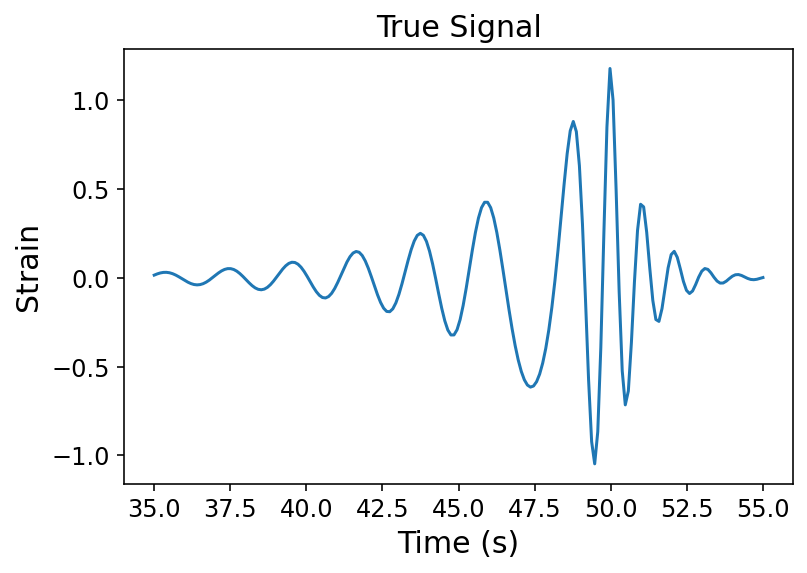

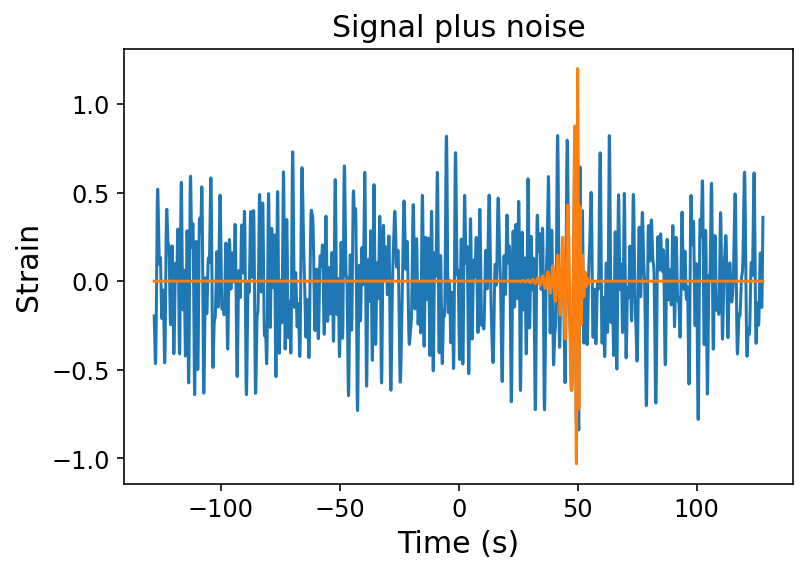

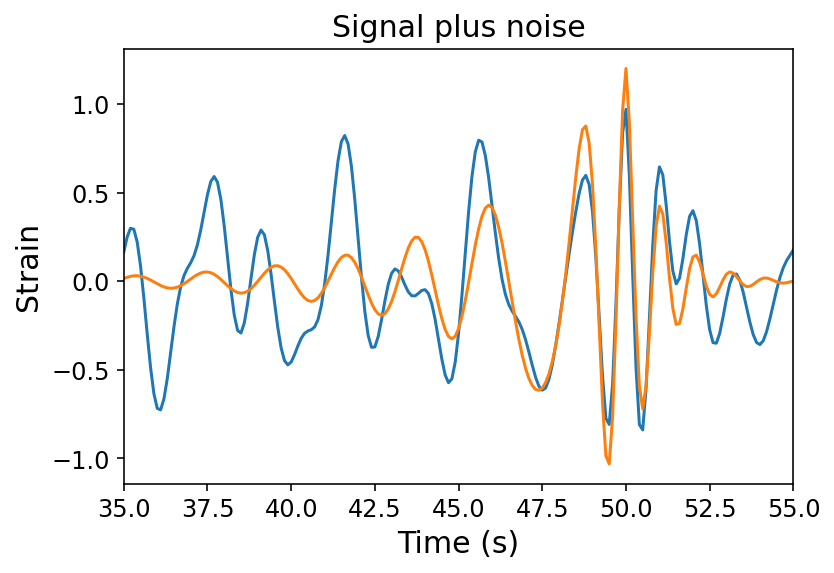

In [100]:
#>>>RUN: P2.7-runcell01

np.random.seed(0x98a09fe)

def complicated_model_fn(x, time, lambda_plus, lambda_minus, max_amp, omega_0, omega_max, omega_sigma):
    omega = (omega_max - omega_0) * (np.exp(-np.minimum(x - time, 0)**2 / omega_sigma)) + omega_0
    lambdas = np.array([lambda_plus if xvalue > time else lambda_minus for xvalue in x])
    amplitude = max_amp * np.exp(-abs(x - time) / lambdas)
    return amplitude * np.cos(omega * (x-time))


params_min_max = {
    'lambda_plus': (0.1, 5),
    'lambda_minus': (0.1, 5),
    'max_amp': (0, 2),
    'omega_0': (0, 5),
    'omega_max': (0, 10),
    'omega_sigma': (0, 5),
}

def get_param_random_value(p_min,p_max):
    #get a uniformly distributed random value between p_min and p_max
    #return a float
    return p_min + (p_max - p_min) * np.random.random(1)[0]

def model_and_random_parameters(t):
    model = Model(complicated_model_fn)
    params = Parameters()
    params.add('time', value=t, vary=False)
    for p, (p_min, p_max) in params_min_max.items():
        value = get_param_random_value(p_min,p_max)
        params.add(p, min=p_min, max=p_max, value=value)
    return model, params


LAMBDA_PLUS_TRUE = 1.0
LAMBDA_MINUS_TRUE = 4
MAX_AMP_TRUE = 1.2
OMEGA_0_TRUE = 3.0
OMEGA_MAX_TRUE = 6.0
OMEGA_SIGMA_TRUE = 4.0
TIME_TRUE = 50.0

xi = np.linspace(TIME_TRUE-15, TIME_TRUE+5, 200)
true_yi = complicated_model_fn(xi, TIME_TRUE, LAMBDA_PLUS_TRUE, LAMBDA_MINUS_TRUE, MAX_AMP_TRUE,
                               OMEGA_0_TRUE, OMEGA_MAX_TRUE, OMEGA_SIGMA_TRUE)

NUMBER_SINES_TO_ADD = 10

noise_frequencies = 0.5 + 7 * np.random.random(NUMBER_SINES_TO_ADD)
noise_phases = 2 * np.pi * np.random.random(NUMBER_SINES_TO_ADD)
noise_amplitudes = 2 * MAX_AMP_TRUE / NUMBER_SINES_TO_ADD * np.random.random(NUMBER_SINES_TO_ADD)
    # The above line sets noise amplitudes so that the sum of all the noise amplitudes is on average
    # equal to the maximum amplitude of the signal.

plt.plot(xi, true_yi)
plt.title("True Signal")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.show()

sample_spacing = 0.1
xi = np.arange(-128, 128, sample_spacing)#times
yi = np.zeros_like(xi)#data

#Adding Noise
for freq, phase, amplitude in zip(noise_frequencies, noise_phases, noise_amplitudes):
    yi += amplitude * np.sin(phase + freq * xi)

#Adding Data
signal= complicated_model_fn(xi, TIME_TRUE, LAMBDA_PLUS_TRUE, LAMBDA_MINUS_TRUE, MAX_AMP_TRUE,
                               OMEGA_0_TRUE, OMEGA_MAX_TRUE, OMEGA_SIGMA_TRUE)
yi+=signal

plt.plot(xi, yi)
plt.plot(xi, signal)
plt.title("Signal plus noise")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.show()

plt.plot(xi, yi)
plt.plot(xi, signal)
plt.title("Signal plus noise")
plt.xlim(35,55)
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.show()

<h3>Plotting the Fit from Before (time-domain)</h3>

Here we plot the fit, defining a slightly different function that will also return the data arrays. Run it multiple times to find the minimum $\chi^2$ value and corresponding maximum $\chi^2$ probability.

**Note:** Since we will use this fit going forward, be sure to run it until the best fit (minimum $\chi^2$) is found and **make sure** that a fit resulting in this lowest value is the **last fit** that you run. To ensure that you end on the correct fit, it's best **not** to use a `for` loop in this case.

Fit chi2 value:  50.16731174963141
Fit chi2 probability:  0.8968375526799567


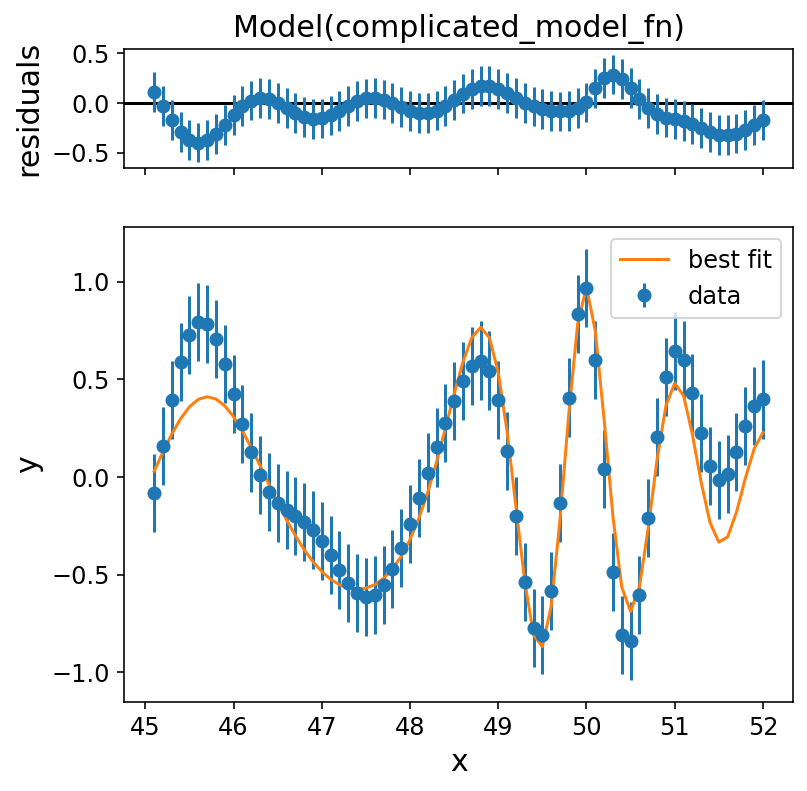

In [101]:
#>>>RUN: P2.7-runcell02

#Getting the fit (defining a slightly different function than previously)

import lmfit


def get_signal_indices(xi, t, t_before, t_after):
    #use np.where() to return a 1D the relevant indices
    #note, the result of np.where() will be a tuple
    return np.where((xi > t - t_before) & (xi < t + t_after))

def fit_once_apply(t, t_before, t_after, weight=1.0):
    data_indices = get_signal_indices(xi, t, t_before, t_after)
    data_x = xi[data_indices]
    data_y = yi[data_indices]
    weights = np.ones(len(data_x))*weight
    model, params = model_and_random_parameters(t)
    result = model.fit(data_y, params, x=data_x,weights=weights)
    fitted_y = model.eval(x=data_x,params=result.params)
    result.plot()
    print("Fit chi2 value: ", result.chisqr)
    print("Fit chi2 probability: ",1-stats.chi2.cdf(result.chisqr,result.nfree))
    return data_x,data_y,fitted_y

t_before = 5
t_after = 2
unc=0.2
fit_x, d_y, fit_y = fit_once_apply(TIME_TRUE, t_before, t_after, 1./unc)
plt.show()

Now, your job is to compute a more meaningful $\chi^{2}$ value by taking the above data and fitted prediction and transforming them into Fourier space and plotting them together.

<a name='problems_7_3'></a>   

| [Top](#section_6_0) | [Restart Section](#section_7_3) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 2.7.1</span>

As a first step, take the data and the fitted function in the time range they were fitted, and plot them in Fourier space. At approximately what frequency value (in Hz) does the amplitude decay to negligible levels? Enter your answer as a number with precision $\pm 0.01$ Hz.


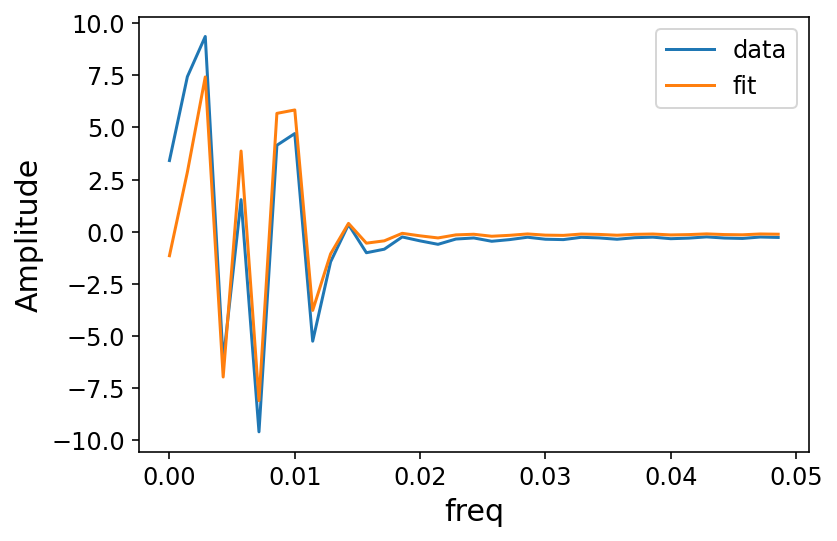

In [102]:
#>>>PROBLEM: P2.7.1

fftdata = np.fft.fft(d_y)
fftfit  = np.fft.fft(fit_y)

freq = np.fft.fftfreq(fit_x.shape[0])*sample_spacing

freq    = freq   [0:freq.shape[0]//2]
fftfit  = fftfit [0:fftfit.shape[0]//2]
fftdata = fftdata[0:fftdata.shape[0]//2]

#print(fftdata.shape,fftfit.shape)
plt.plot(freq,fftdata.real,label='data')
plt.plot(freq,fftfit.real,label='fit')
plt.xlabel('freq')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 2.7.2 </span>

Now, we want to compute the noise as a function of frequency. We can do this by taking a region where there is no signal and computing the standard deviation of our samples in Fourier space. Notice that the code does this in each of the same frequency bins that were used to compute the FFT, and uses `np.stddev(axis=0)` to compute the standard deviation of a 2D array.

Run the code below. What does this noise spectrum look like? Choose from the following options:

- A uniform distribution across all frequencies.
- A decaying exponential function, peaked at low frequencies.
- An increasing exponential function, peaked at high frequencies.
- A function with multiple peaks in the low frequency range, decreasing in the high frequency range.
- A function with multiple peaks in the high frequency range, decreasing in the low frequency range.


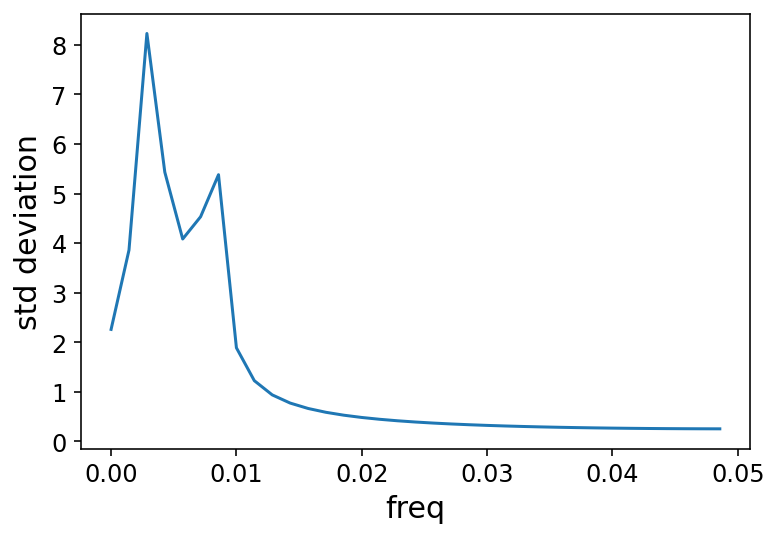

In [103]:
#>>>PROBLEM: P2.7.2

def fft_region(t, t_before, t_after):
    data_indices = get_signal_indices(xi, t, t_before, t_after)
    data_x = xi[data_indices]
    data_y = yi[data_indices]
    fft_sample = np.fft.fft(data_y)
    fft_sample=fft_sample[0:fft_sample.shape[0]//2]
    return fft_sample

tsample=np.arange(-128, 128,10)

t_before = 5
t_after = 2

ffts=np.array([])
for t in tsample:
    if abs(t-TIME_TRUE) > 10:
        pfft=fft_region(t, t_before, t_after)
        if pfft.shape[0] == 35:
            ffts = np.append(ffts,pfft)
            
ffts   = np.reshape(ffts,(len(ffts)//35,35))
stddev = ffts.std(axis=0)
plt.plot(freq,stddev)
plt.xlabel('freq')
plt.ylabel('std deviation')
plt.show()

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 2.7.3 </span>

Finally, make a plot of the Fourier transforms of the data and the best time-domain fit, similar to what was done at the beginning of this section, but now in frequency space. Include error bars on each data point equal to the standard deviation of the corresponding frequency found in P7.3.1 above.

What is the $\chi^{2}$ value between the data and the fit (i.e. $\sum (\textrm{data}-\textrm{fit})^2/\textrm{unc}^2$) and its associated probability? Note that the number of degrees of freedom is the number of bins minus the number of fit parameters, the latter being 7 in this case.

Enter your answer as a list of numbers `[chi2, chi2_prob]` with precision 1e-1.  

**NOTE: make sure you perform this analysis with respect to the time-domain fit that yielded the lowest $\chi^2$ value.**

/Users/Josh/miniconda3/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/Josh/miniconda3/lib/python3.11/site-packages/numpy/ma/core.py:3371: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


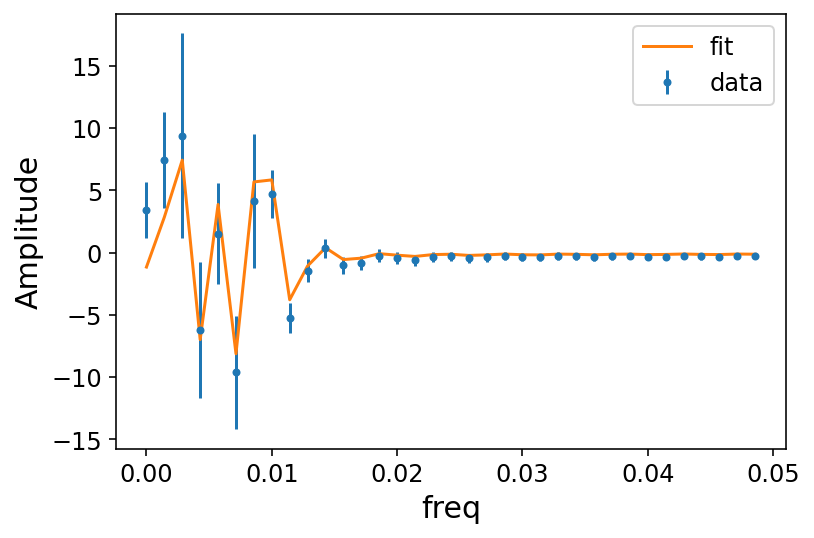

In [110]:
# plotting
plt.errorbar(freq,fftdata,yerr=stddev,label='data',marker='.',linestyle='None')
plt.plot(freq,fftfit,label='fit')
plt.xlabel('freq')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [112]:
chi2tot = np.sum(np.abs((fftdata - fftfit)**2) / stddev**2)

print("Fit chi2 value: ", chi2tot)
print("Fit chi2 probability: ",1-stats.chi2.cdf(chi2tot,len(fftdata)-7))

Fit chi2 value:  19.893495977523088
Fit chi2 probability:  0.8683158329600191


>#### Follow-up 2.7.3a (ungraded)
>   
>Why is the fit probability found using this frequency-domain technique more meaningful than the p-value obtained from the time-domain fit itself?